In [64]:
from tbparse import SummaryReader
from typing import List

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

plt.style.use('ggplot')

In [65]:
with open('../config.json') as f:
    config = json.load(f)
BASE_DIR = config["BASE_DIR_CGI_CKPT_MAC"]
VIS_DIR = config["BASE_DIR_VIS"]

In [66]:
def extract_df(log_dir):
    reader = SummaryReader(log_dir)
    df = reader.scalars
    df = df.pivot_table(index='step', columns='tag', values='value', aggfunc='first')
    df = df.reset_index()
    return df

In [67]:
def plot(df:pd.DataFrame) -> None:
    for col in df.columns:
        df_local = df[col].dropna()
        series = df_local
        plt.figure(figsize=(10, 5))
        plt.plot(series, label=col)
        plt.title(col)
        plt.xlabel('Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

In [68]:
name_conversion = {
    'Sceneflow': 'SceneFlow',
    'ScapeOriginal': 'Original H',
    'ScapeOriginal_pretrained': 'Original w/pre H',
    'ScapeCombined': 'Combined H',
    'ScapeCombined_pretrained': 'Combined w/pre H',
    'ScapeCombinedAugmented': 'Combined w/aug H',
    'ScapeCombinedAugmented_pretrained': 'Combined w/aug & pre H',
}

In [69]:
def tensorboard_log_to_df(BASE_DIR:str, list_of_event_files:List[str], name_conversion:dict, show:bool=False) -> pd.DataFrame:
    main_df = pd.DataFrame()

    for log_dir in list_of_event_files:
        results = pd.DataFrame()
        # df = extract_df(os.path.join(BASE_DIR, log_dir))
        df = extract_df(log_dir)

        name = log_dir.split('/')[-2]
        print(f"Pivoted DataFrame: {name_conversion.get(name)}")

        lowest_loss = df['validation/loss_0'].idxmin()
        results[f'{name_conversion.get(name)}'] = df.loc[lowest_loss]
        results = results.T
        results = results[['step', 'train/loss_0', 'validation/loss_0', 'validation/D1_0', 'validation/EPE_0', 'validation/Thres1_0', 'validation/Thres2_0', 'validation/Thres3_0']]
        results.rename(columns={
            'step'                : 'epoch',
            'train/loss_0'        : 'train loss',
            'validation/loss_0'   : 'val. loss',
            'validation/D1_0'     : 'val. D1',
            'validation/EPE_0'    : 'val. EPE',
            'validation/Thres1_0' : 'val. Thres1',
            'validation/Thres2_0' : 'val. Thres2',
            'validation/Thres3_0' : 'val. Thres3',
            }, inplace=True)
        results = results.round(4)

        if show:
            print(results.to_markdown())
            # print(results.T.to_latex())
            # display(results)

        main_df = pd.concat( [main_df, results], axis=0)

    order = [name_conversion.get(name) for name in name_conversion]
    main_df = main_df.reindex(order)

    return main_df

In [70]:
column_plot_combinations = {
    'training loss': ['train/loss_0'],
    'validation loss': ['validation/loss_0'],
    'training and validation loss comparison': ['train/loss_0', 'validation/loss_0'],
    'D1 score': ['validation/D1_0'],
    'End point error': ['validation/EPE_0'],
    'Threshold 1': ['validation/Thres1_0'],
    'Threshold 2': ['validation/Thres2_0'],
    'Threshold 3': ['validation/Thres3_0'],
}

In [71]:
model_colors = {
    'SceneFlow':                         '#FF0000', # Red
    'ScapeOriginal':                     '#0072B2', # Blue
    'ScapeOriginal_pretrained':          '#009E73', # Green
    'ScapeCombined':                     '#D55E00', # Orange
    'ScapeCombined_pretrained':          '#CC79A7', # Purple
    'ScapeCombinedAugmented':            '#F0E442', # Yellow
    'ScapeCombinedAugmented_pretrained': '#56B4E9', # Light Blue
}

# HALF

In [ ]:
list_of_log_dirs = [os.path.join(BASE_DIR, event) for event in os.listdir(BASE_DIR) if not event.startswith('.')]

list_of_event_files = []
for event in list_of_log_dirs:
    if "Full" in event:
        continue
    event_file = [event for event in os.listdir(event) if event.startswith('events')]
    if event_file:
        event_file = os.path.join(event, event_file[0])
        list_of_event_files.append(event_file)

# list_of_event_files

In [73]:
main_df1 =  tensorboard_log_to_df(BASE_DIR, list_of_event_files, name_conversion, show=True)

Pivoted DataFrame: SceneFlow
|           |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:----------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| SceneFlow |      98 |        1.253 |      0.6111 |    0.0202 |     0.6152 |         0.069 |        0.0356 |        0.0255 |


Pivoted DataFrame: Original H
|            |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-----------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| Original H |      95 |       0.7946 |      0.9594 |    0.0503 |     0.9594 |        0.1583 |        0.0888 |        0.0657 |
Pivoted DataFrame: Combined H
|            |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-----------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| Combined H |     100 |       0.5703 |      0.6298 |    0.0284 |     0.6298 |        0.1198 |        0.0648 |        0.0425 |
Pivoted DataFrame: Combined w/aug H
|                  |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-------

In [74]:
main_df1 = main_df1.round(3)
print(main_df1.to_markdown())

|                        |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-----------------------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| SceneFlow              |      98 |        1.253 |       0.611 |     0.02  |      0.615 |         0.069 |         0.036 |         0.026 |
| Original H             |      95 |        0.795 |       0.959 |     0.05  |      0.959 |         0.158 |         0.089 |         0.066 |
| Original w/pre H       |     100 |        0.956 |       1.211 |     0.057 |      1.211 |         0.255 |         0.126 |         0.077 |
| Combined H             |     100 |        0.57  |       0.63  |     0.028 |      0.63  |         0.12  |         0.065 |         0.042 |
| Combined w/pre H       |      97 |        0.861 |       1.085 |     0.048 |      1.085 |         0.23  |         0.095 |         0.062 |
| Combined w/aug H       | 

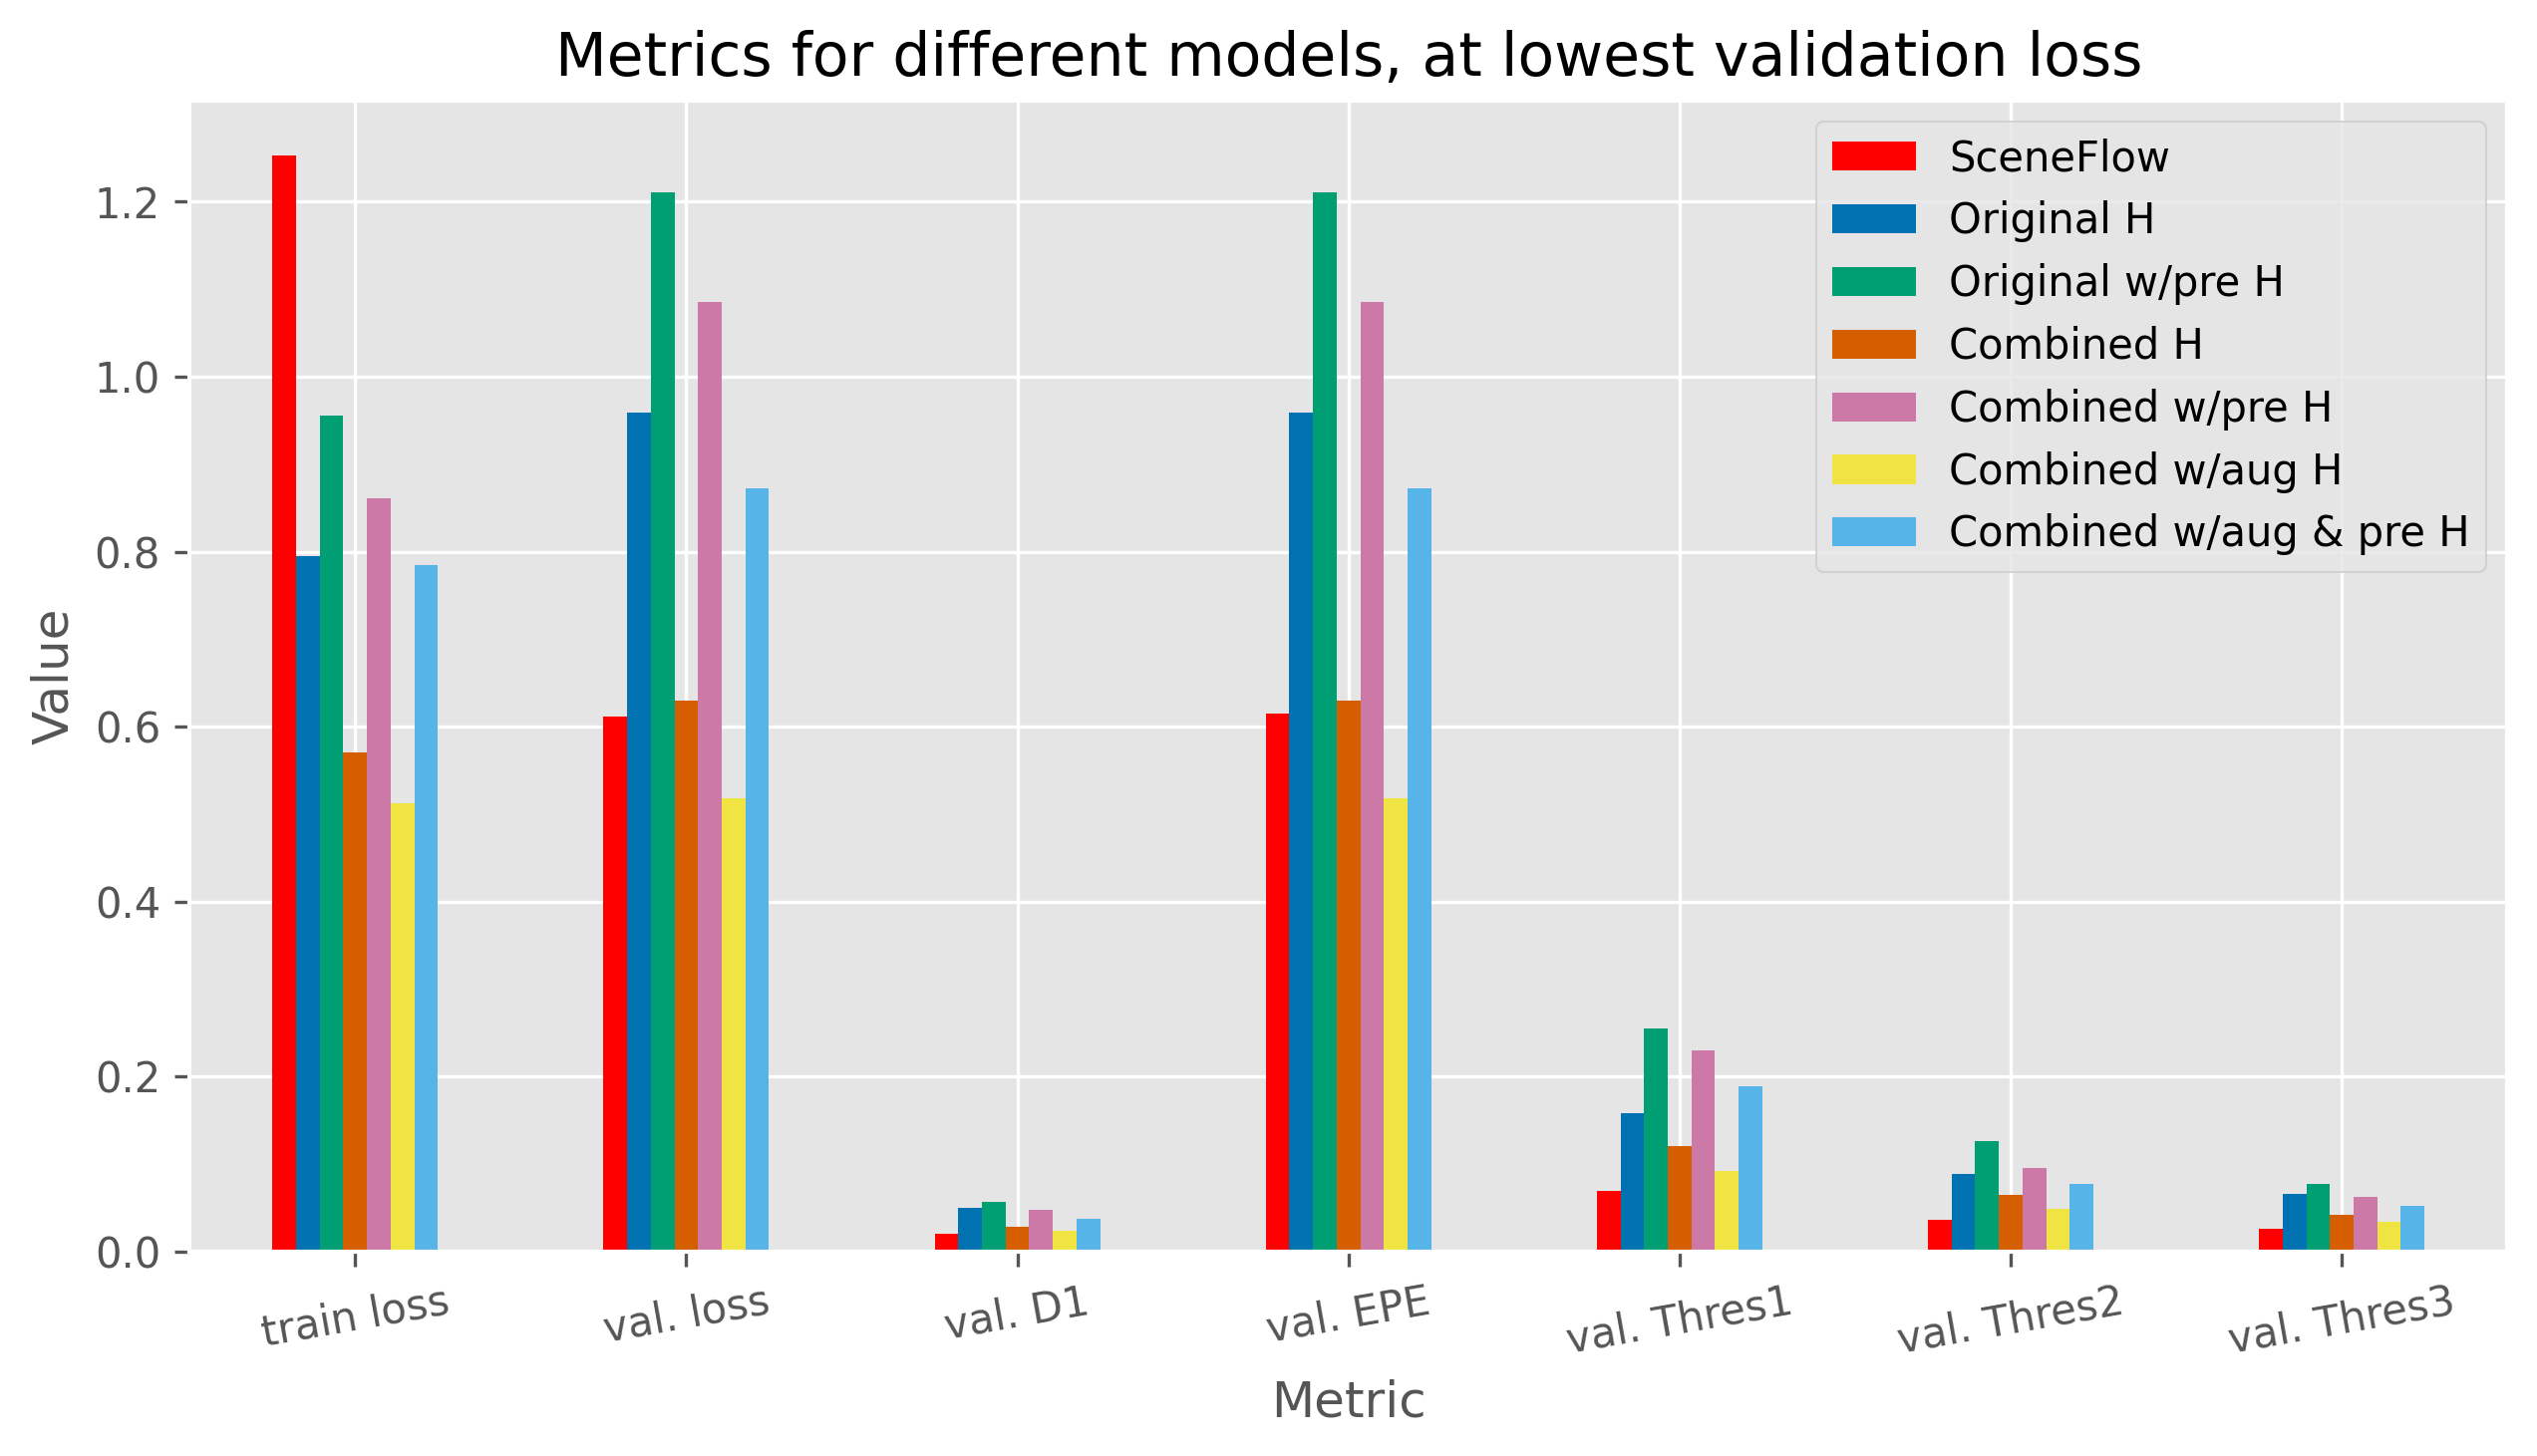

In [75]:
plot_df = main_df1.T.copy()
plot_df = plot_df.drop('epoch')
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

plot_df.plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Metrics for different models, at lowest validation loss',
    ylabel='Value', 
    xlabel='Metric', 
    rot=10,
    color = ['#FF0000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9'],
    ax=ax
)
plt.show()

In [76]:
SceneFlow        = extract_df(os.path.join(BASE_DIR, 'Sceneflow'))
Original         = extract_df(os.path.join(BASE_DIR, 'ScapeOriginal'))
Original_pre     = extract_df(os.path.join(BASE_DIR, 'ScapeOriginal_pretrained'))
Combined         = extract_df(os.path.join(BASE_DIR, 'ScapeCombined'))
Combined_pre     = extract_df(os.path.join(BASE_DIR, 'ScapeCombined_pretrained'))
Combined_aug     = extract_df(os.path.join(BASE_DIR, 'ScapeCombinedAugmented'))
Combined_aug_pre = extract_df(os.path.join(BASE_DIR, 'ScapeCombinedAugmented_pretrained'))

training loss


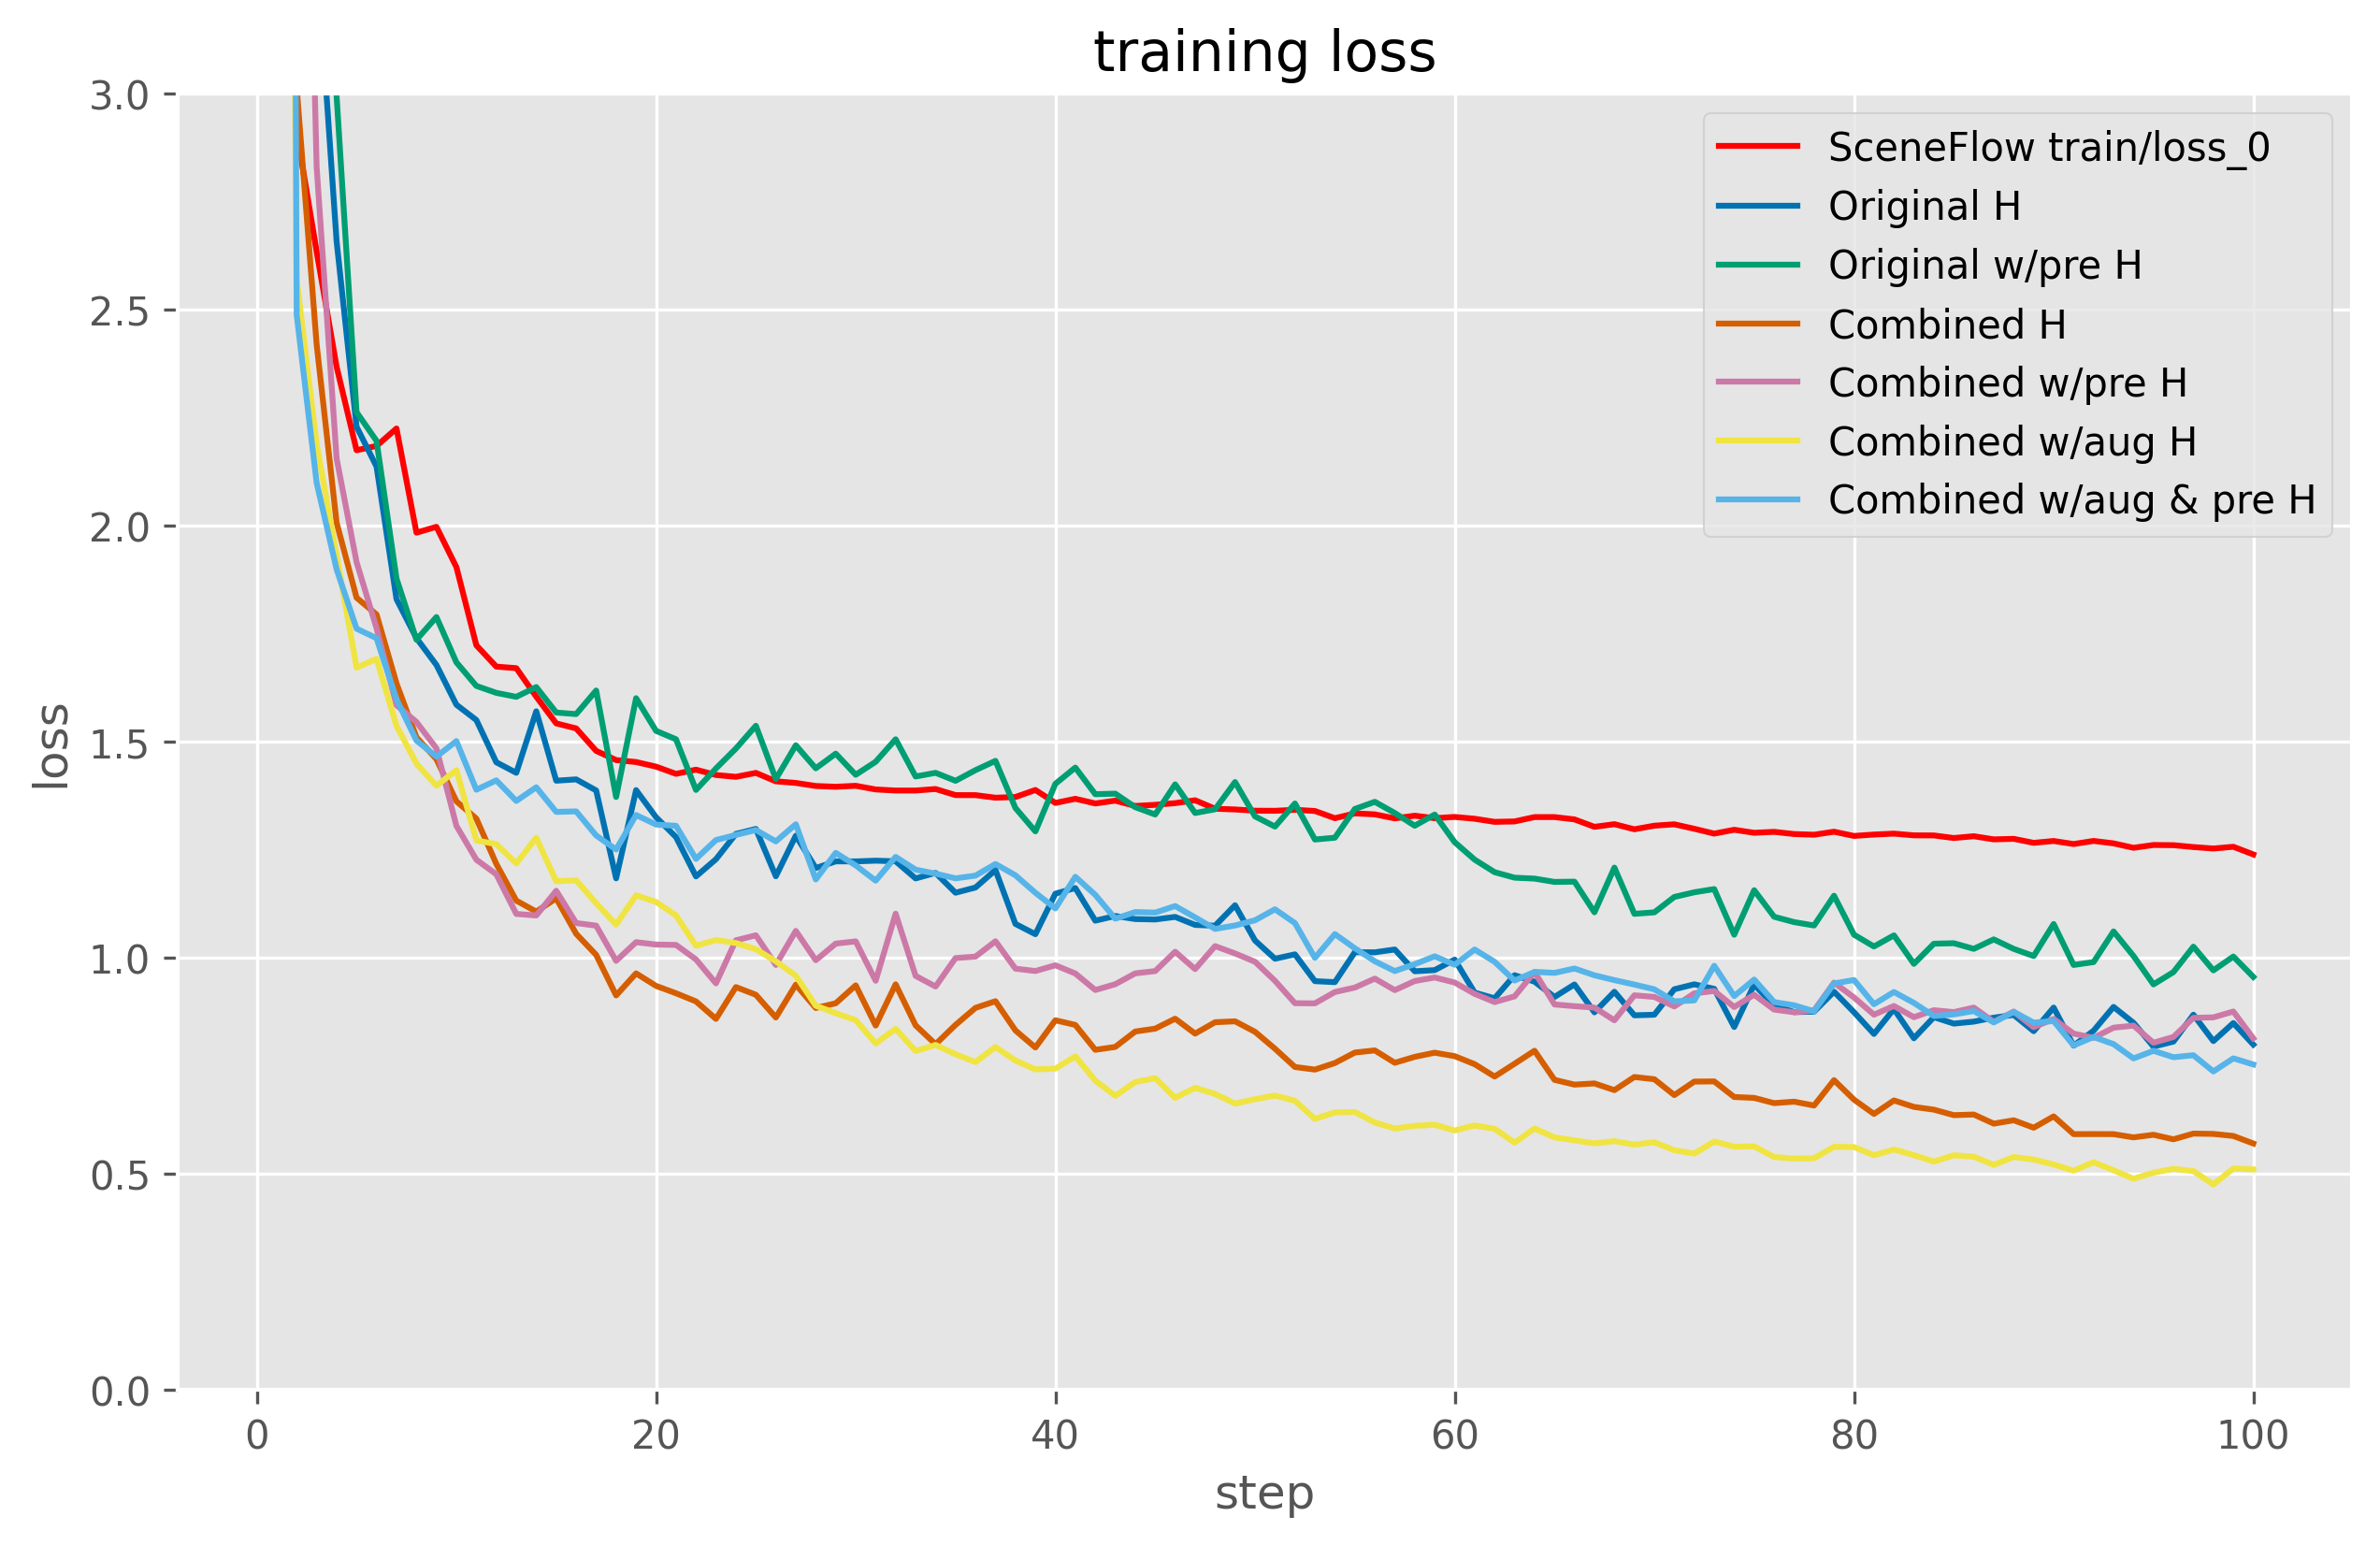

validation loss


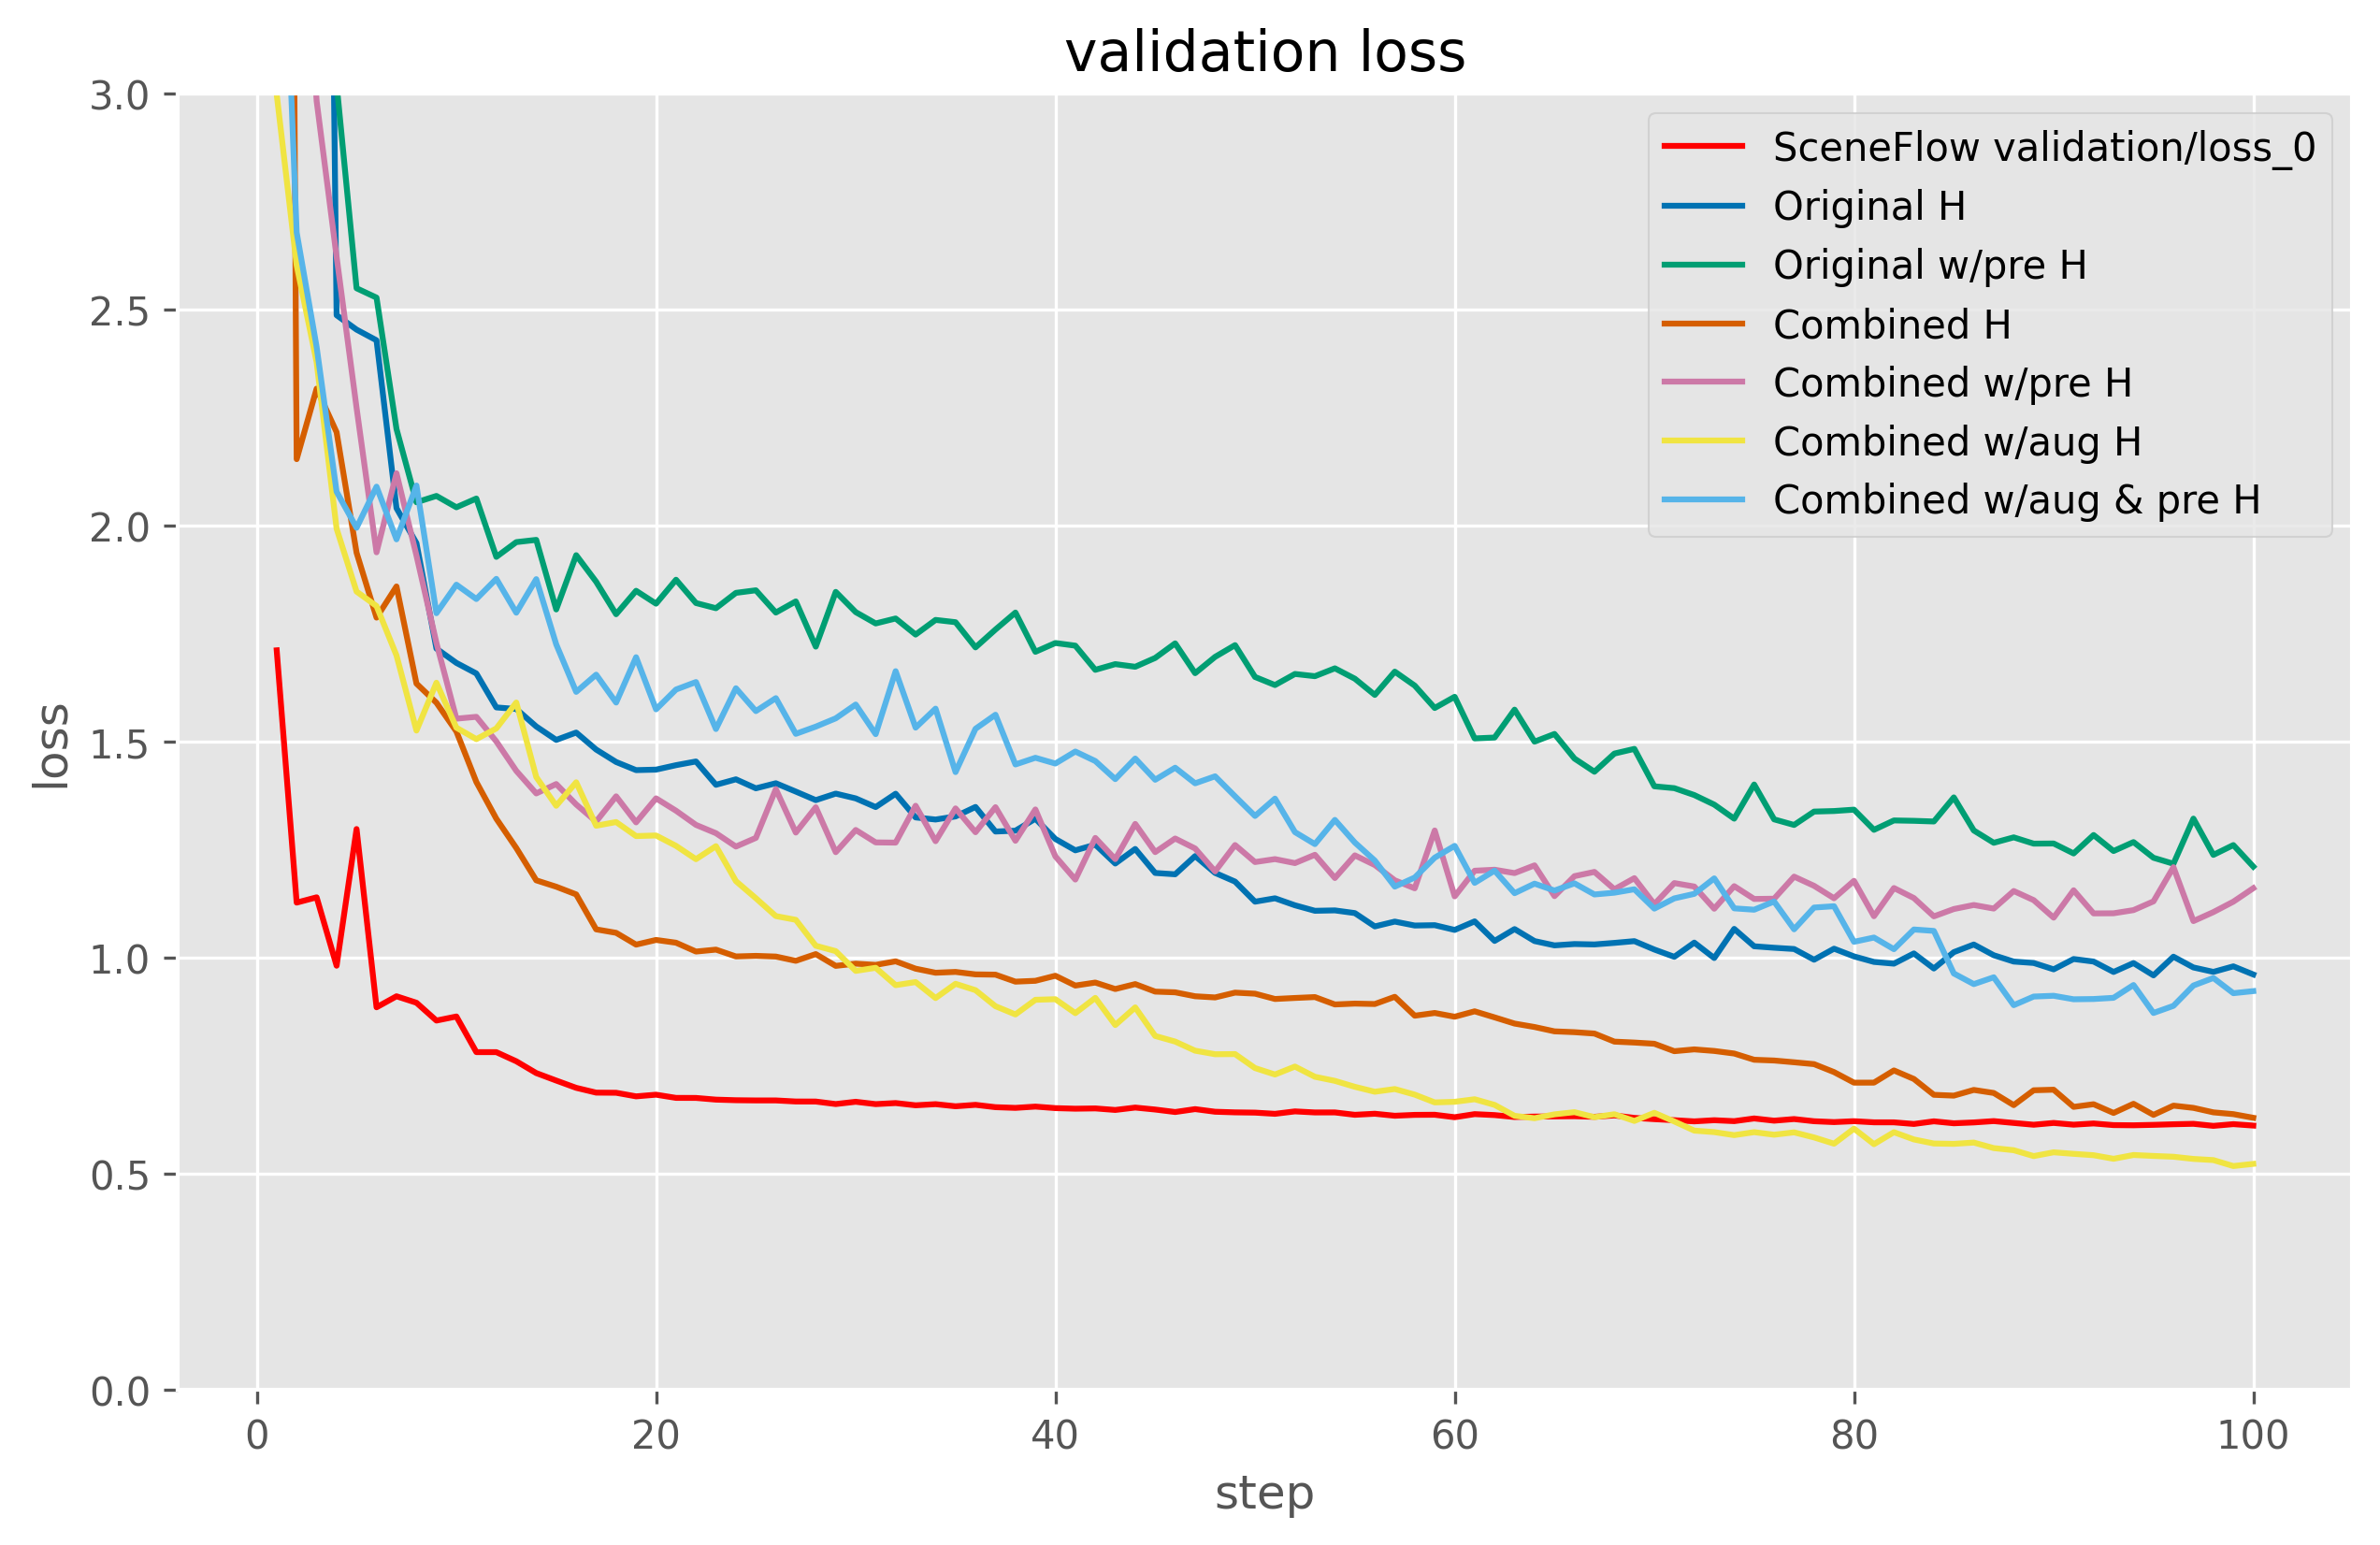

training and validation loss comparison


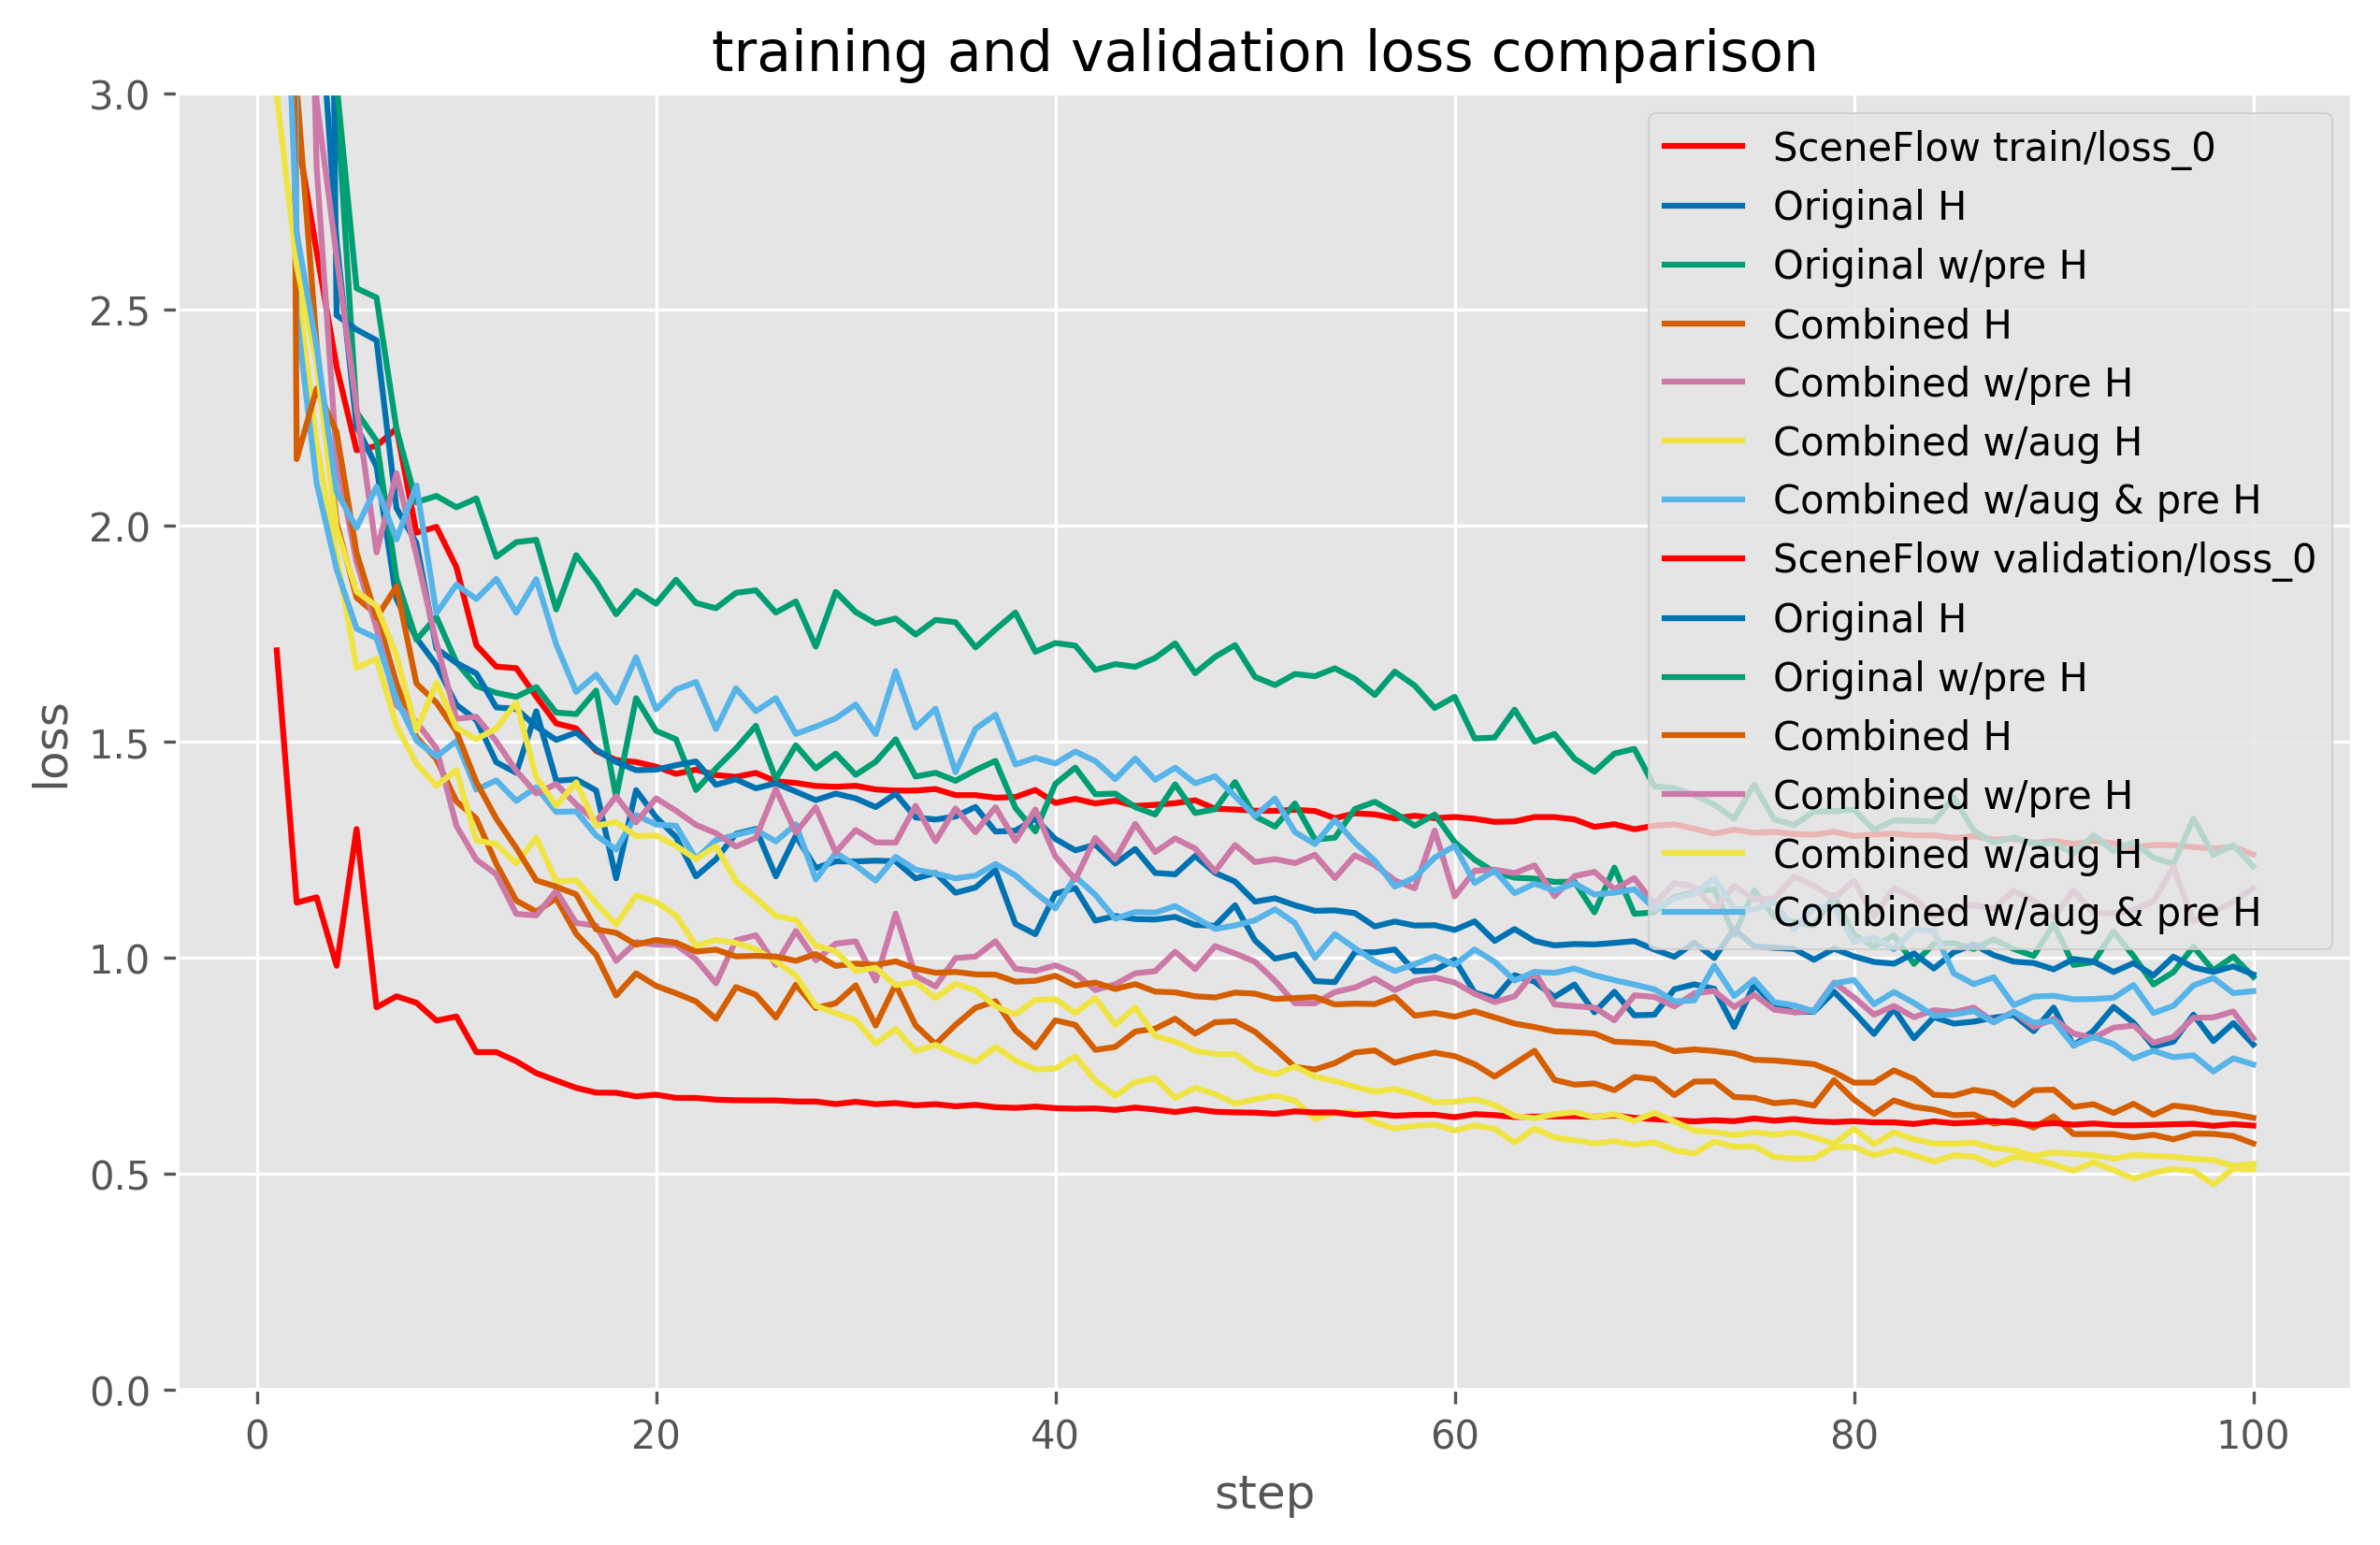

D1 score


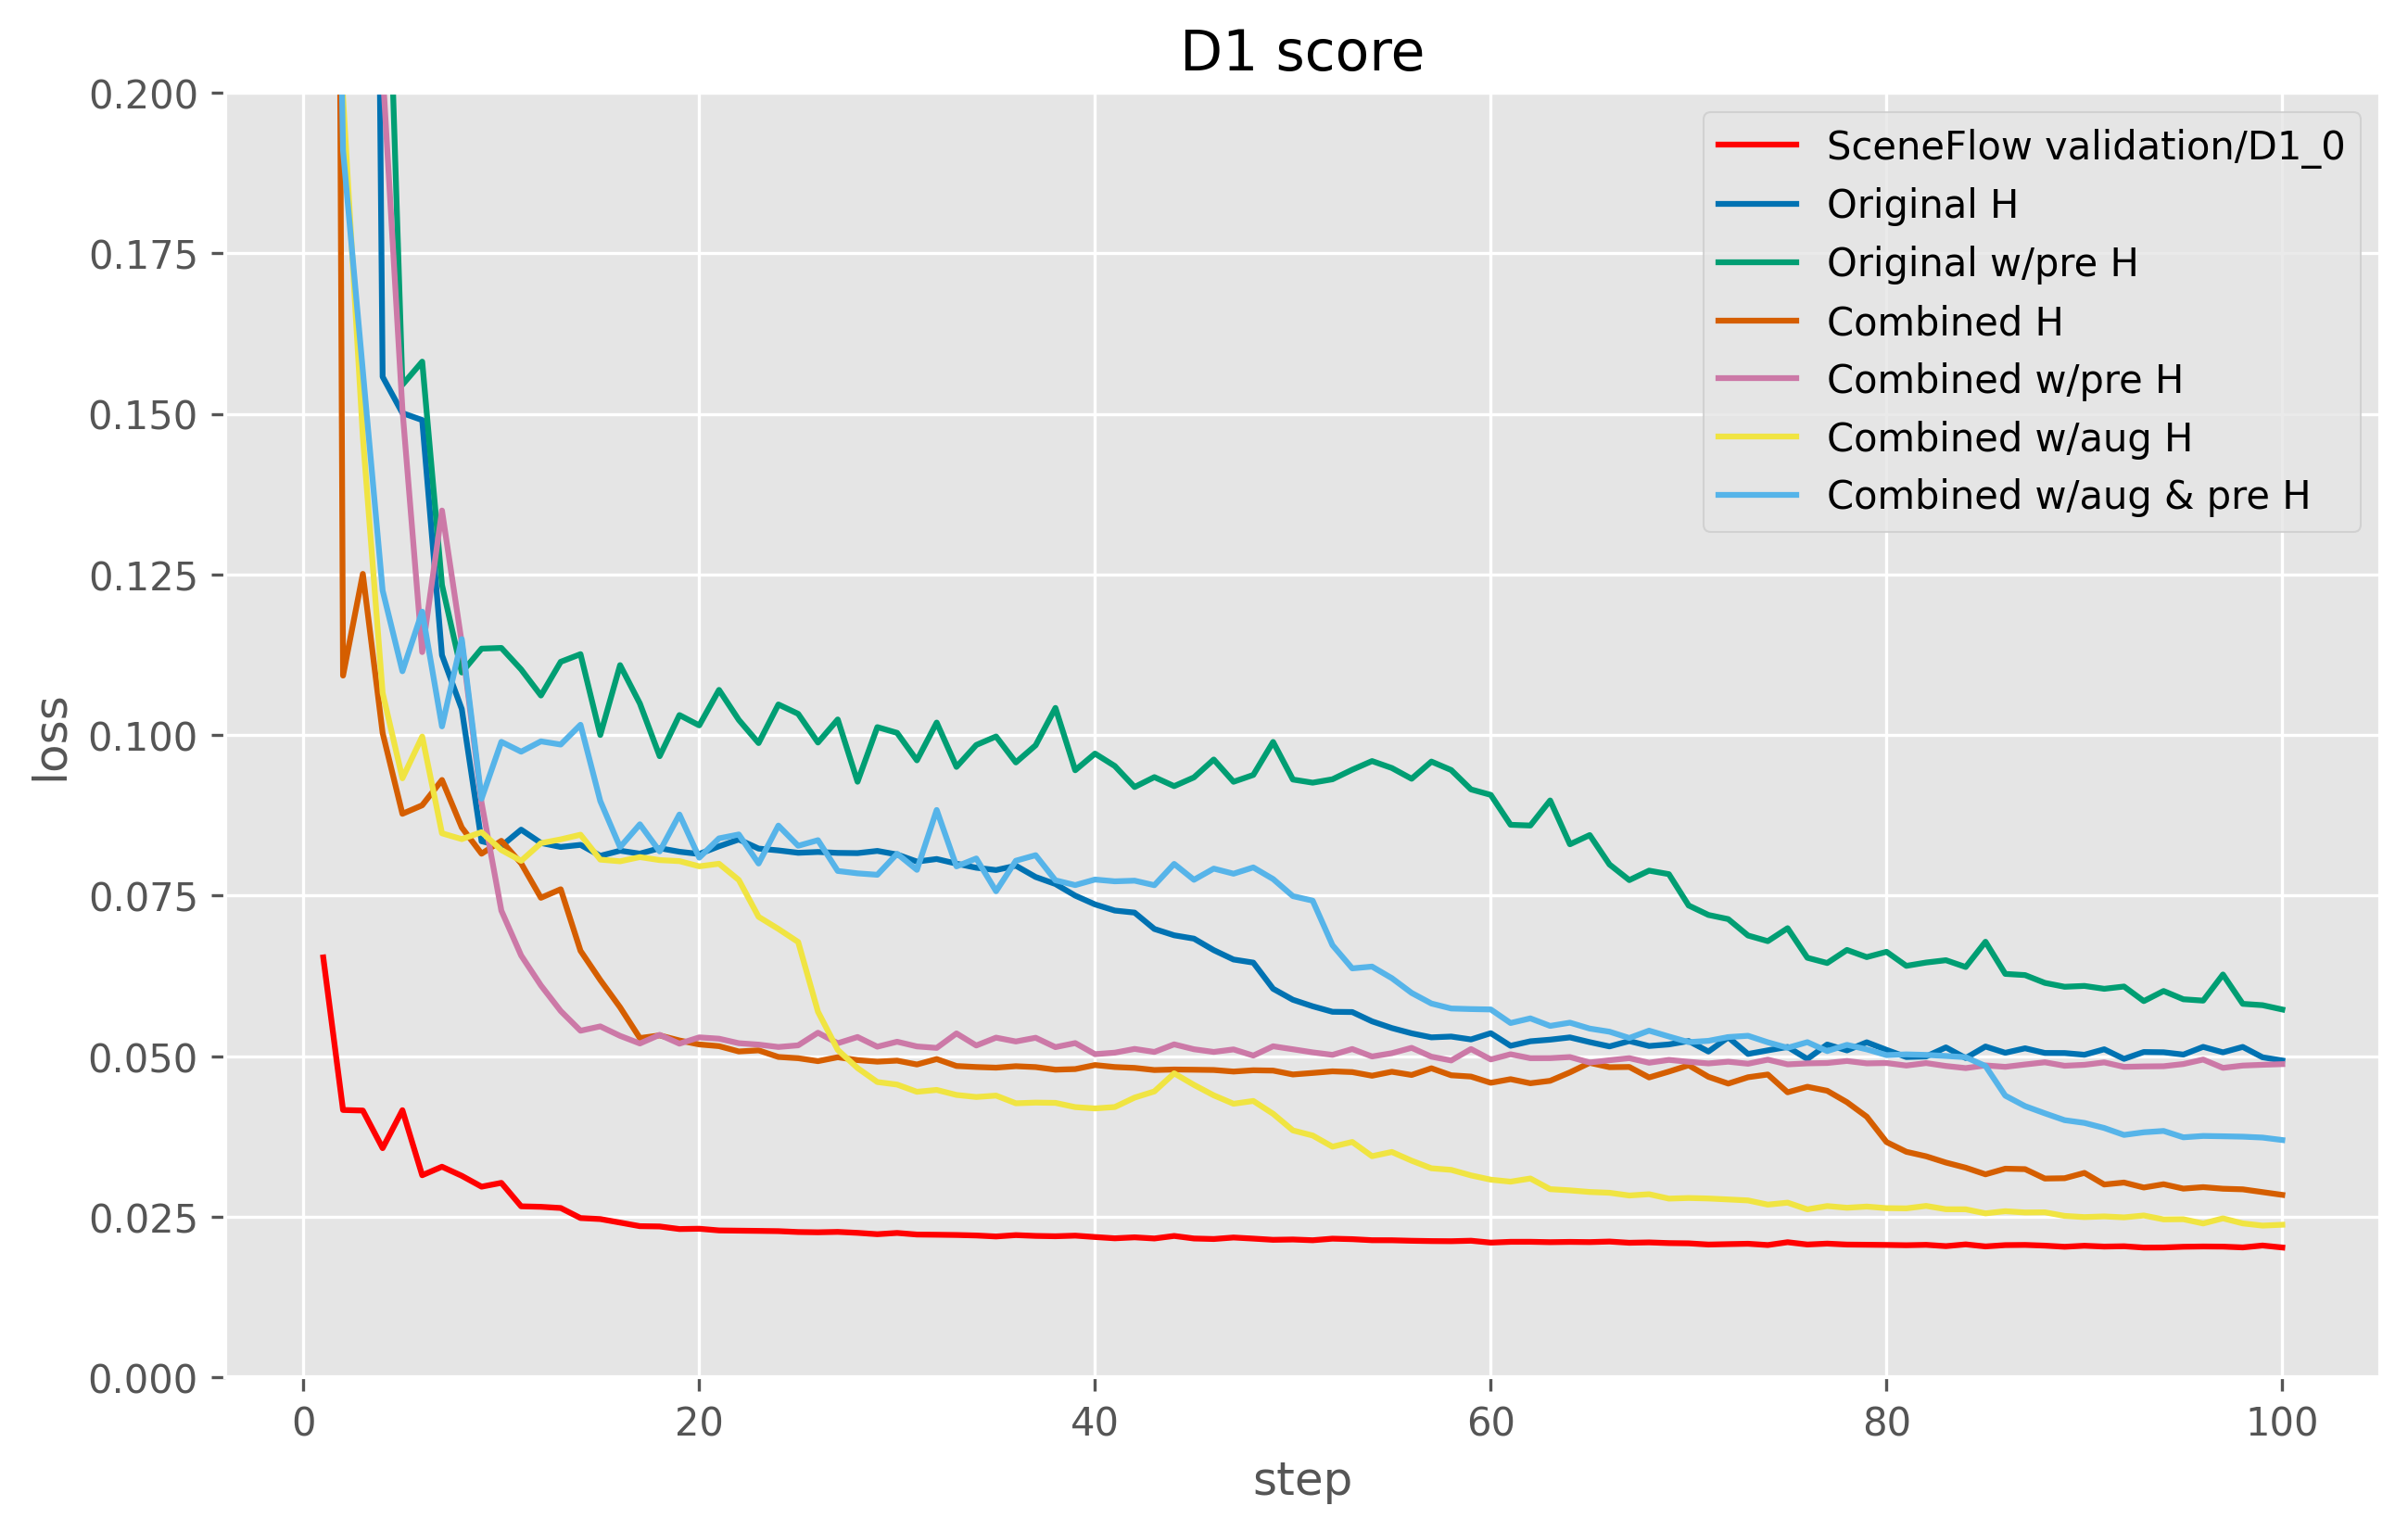

End point error


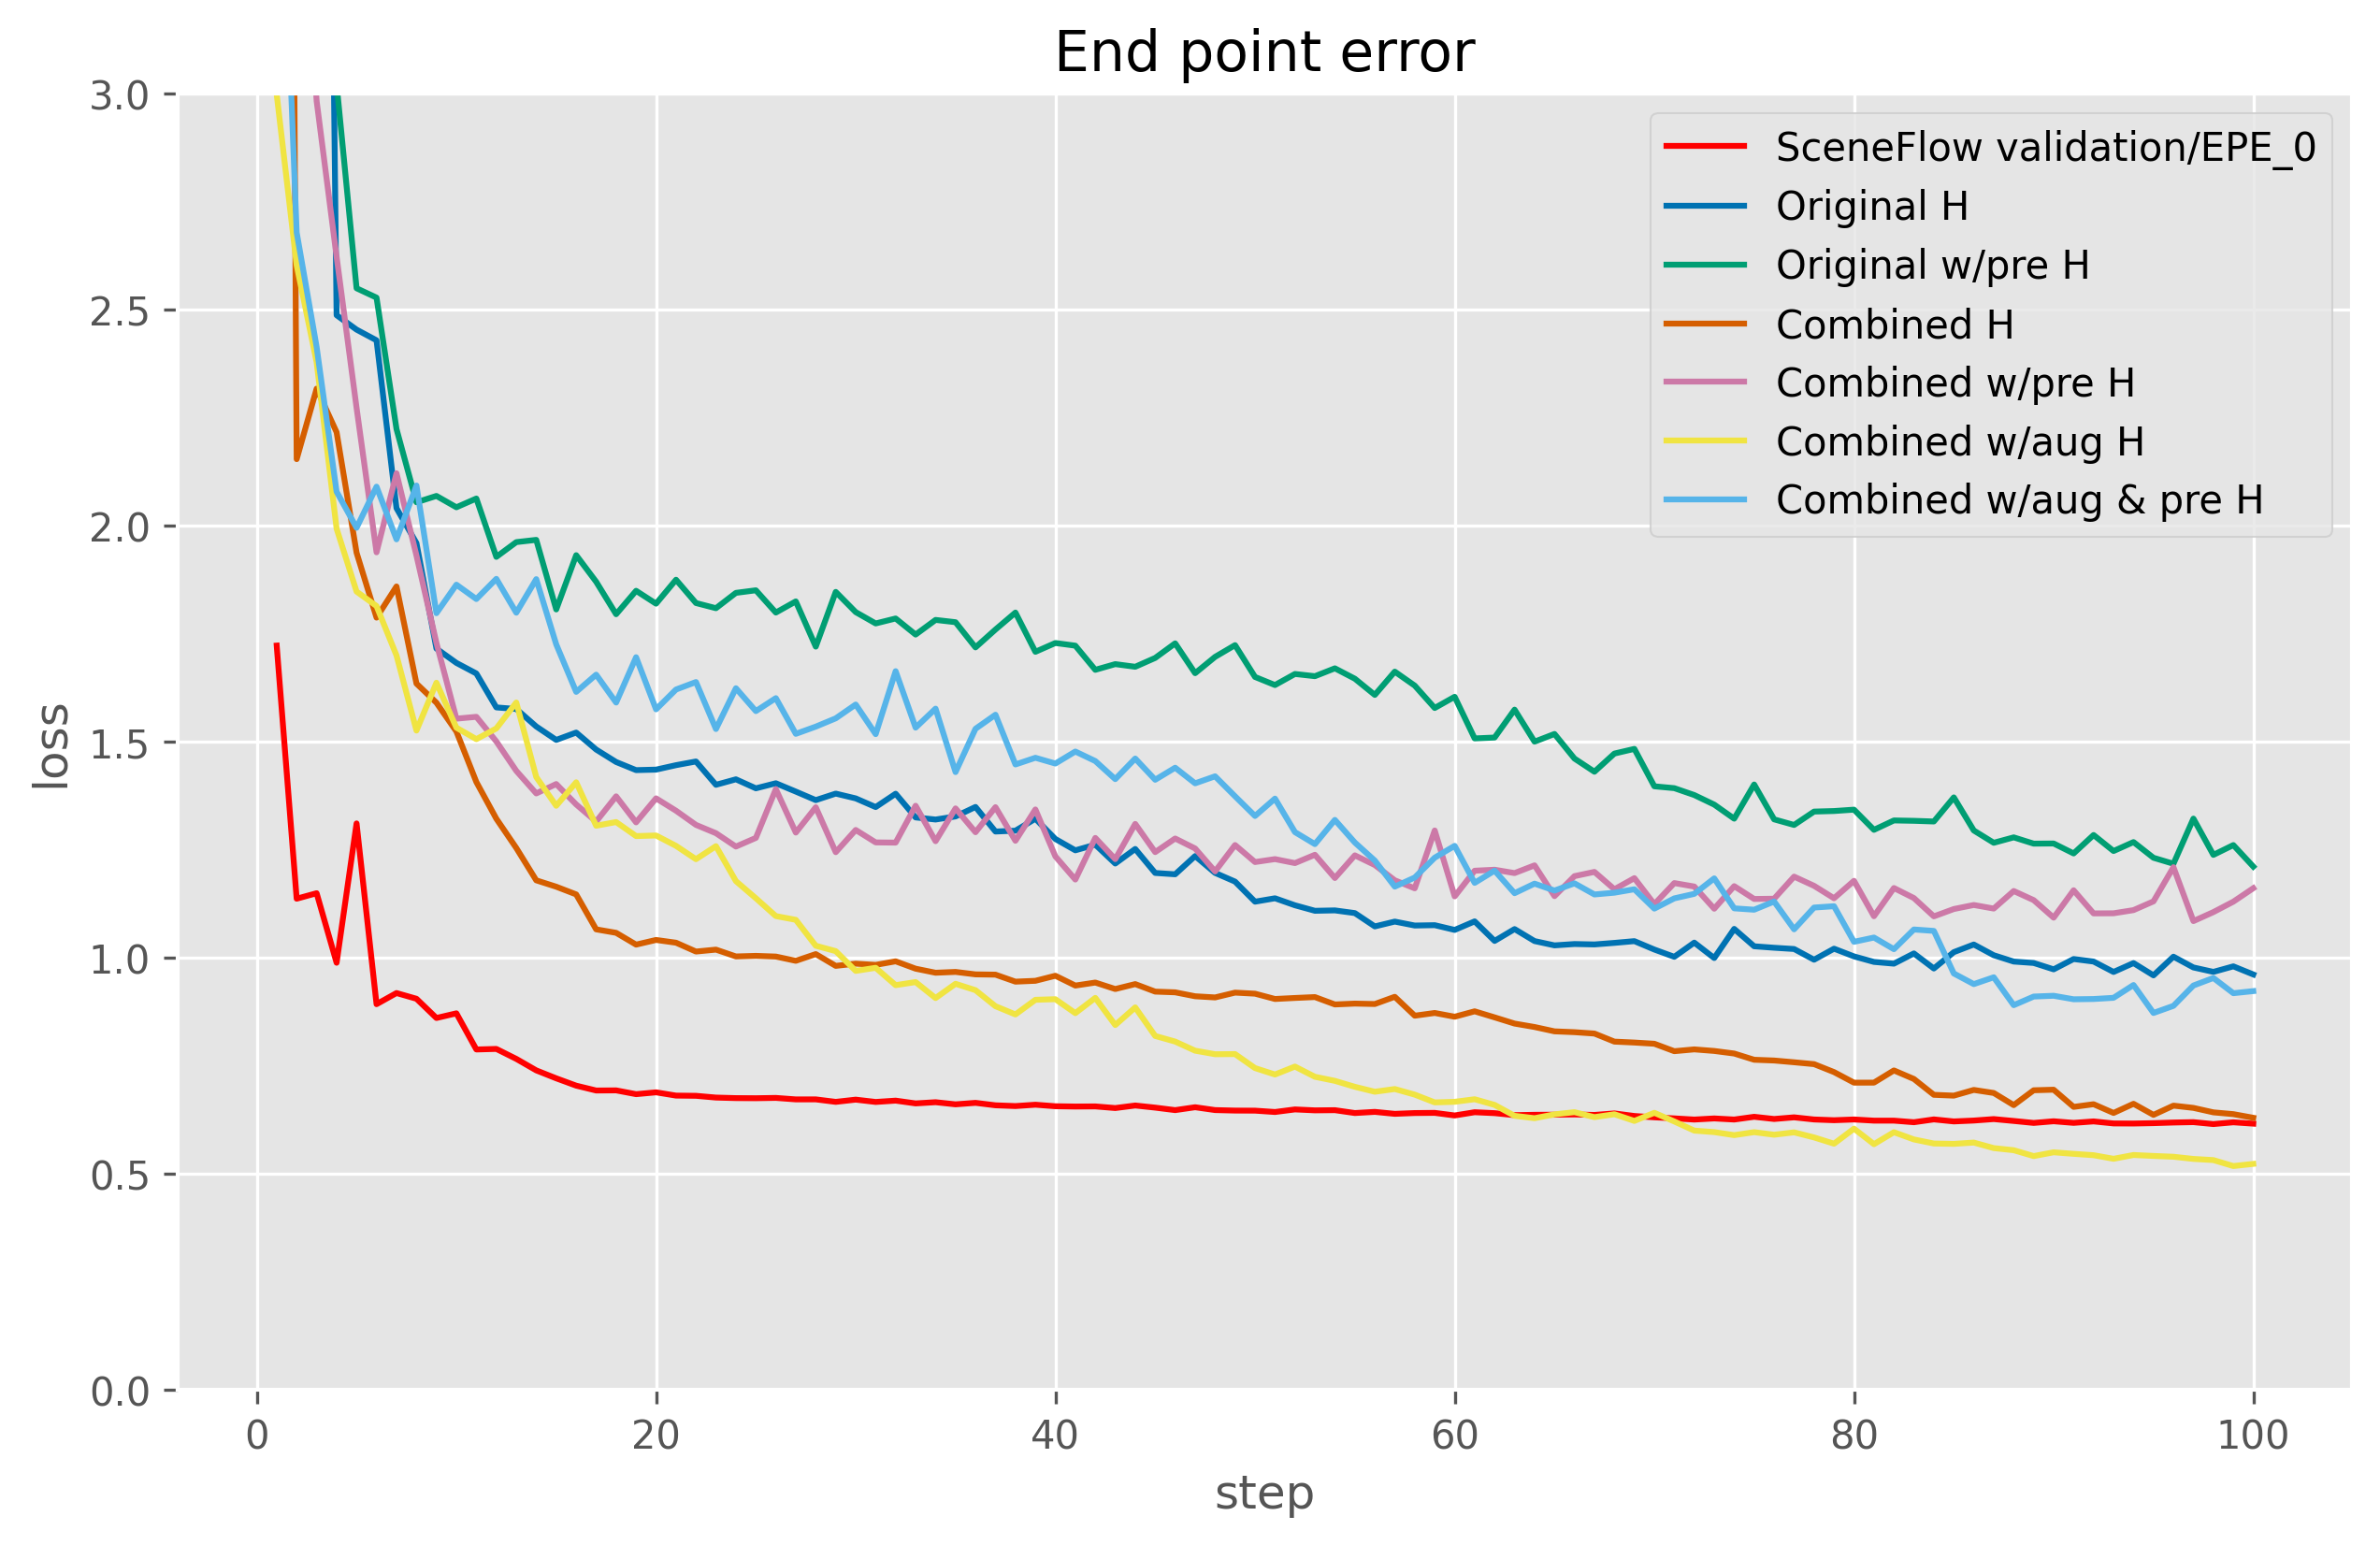

Threshold 1


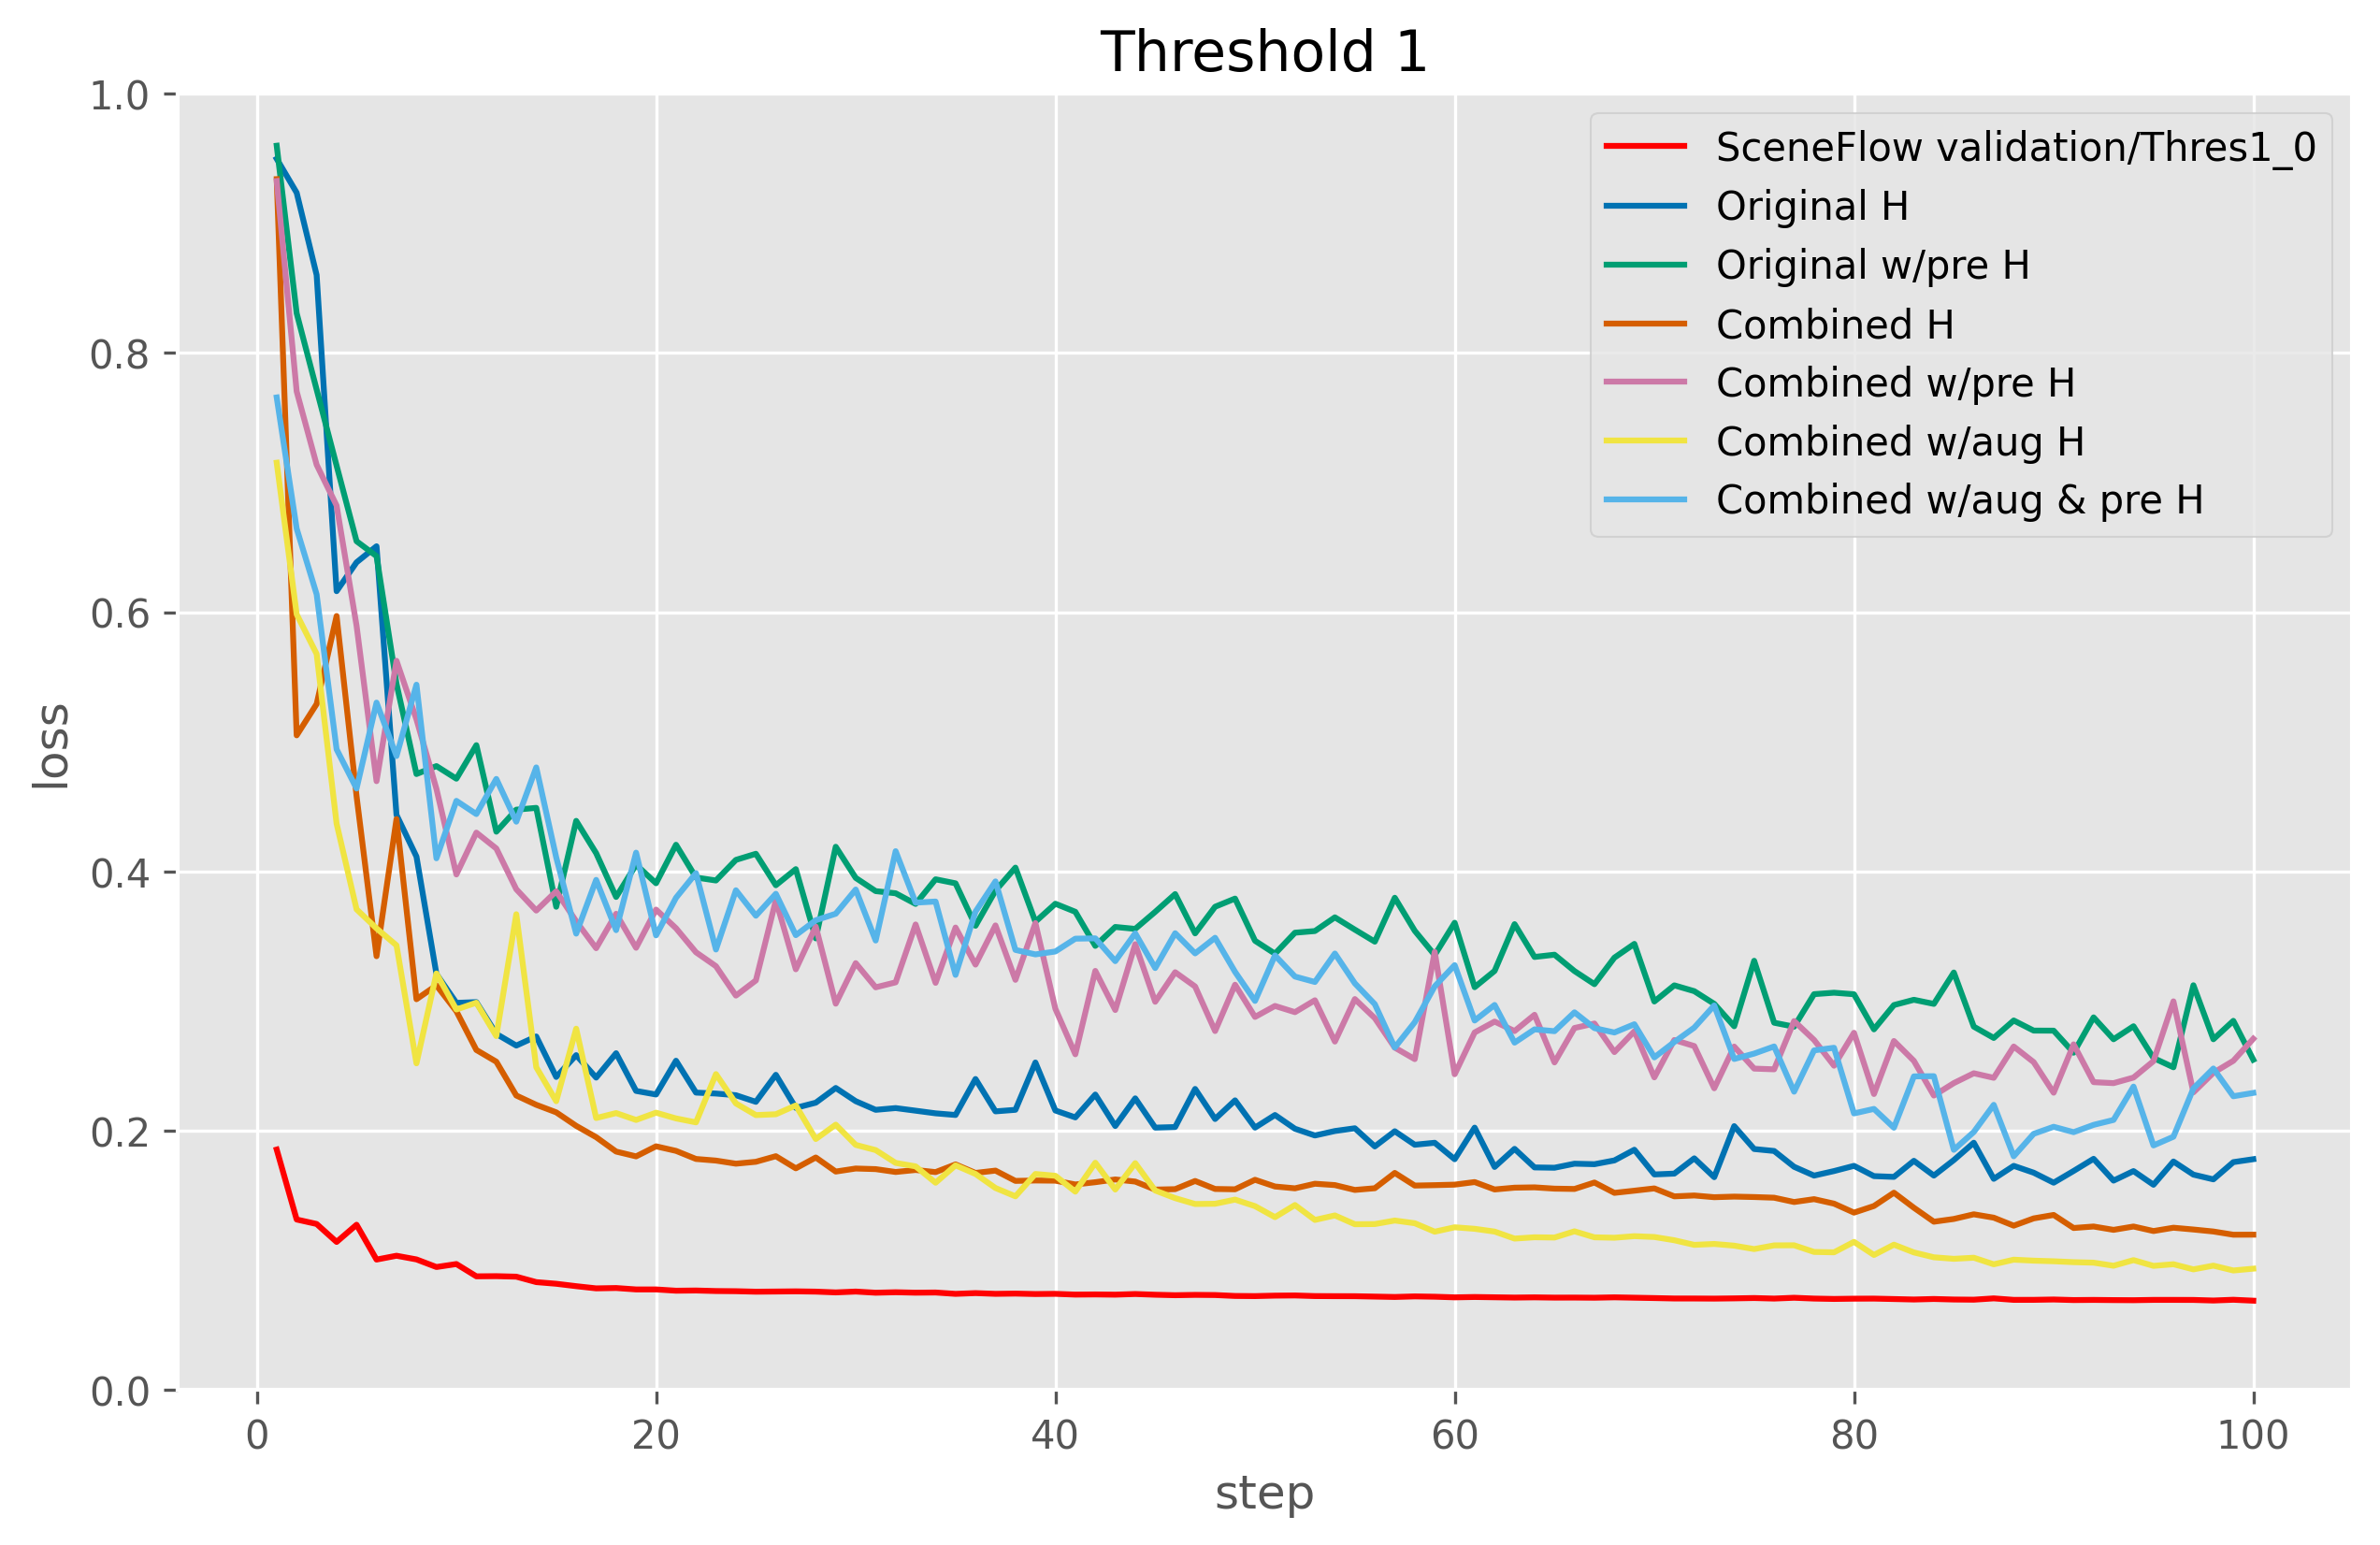

Threshold 2


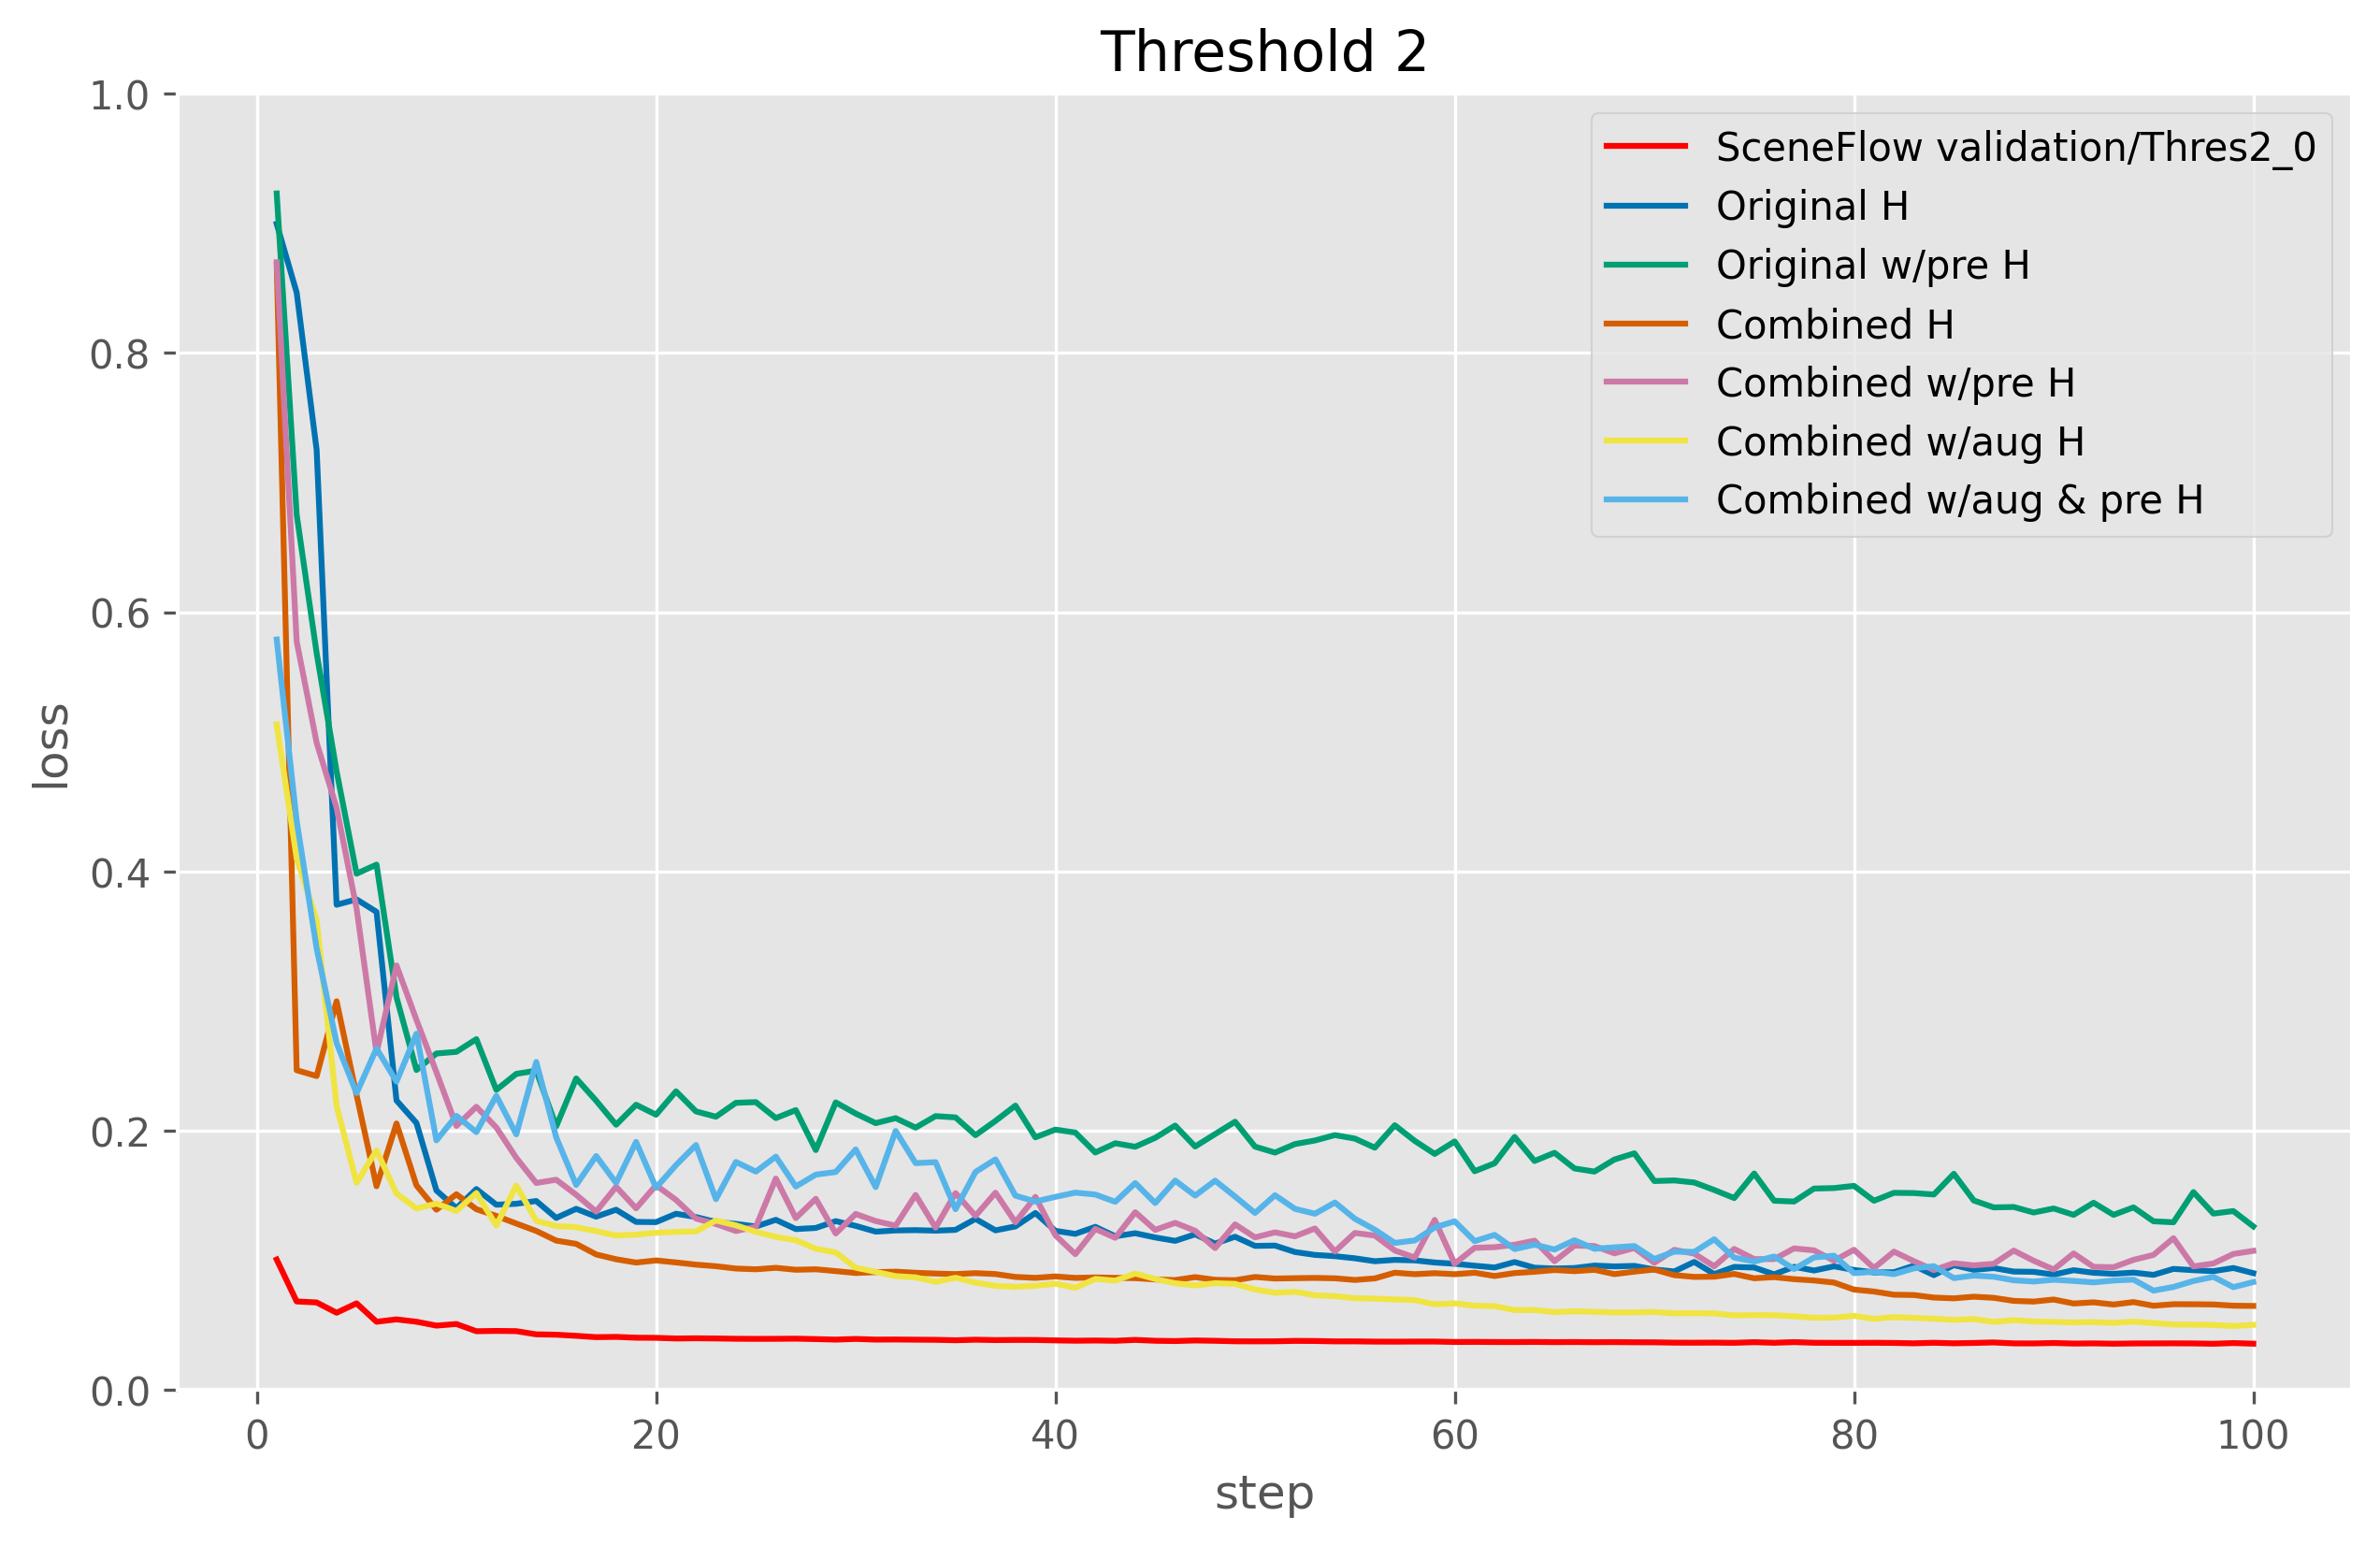

Threshold 3


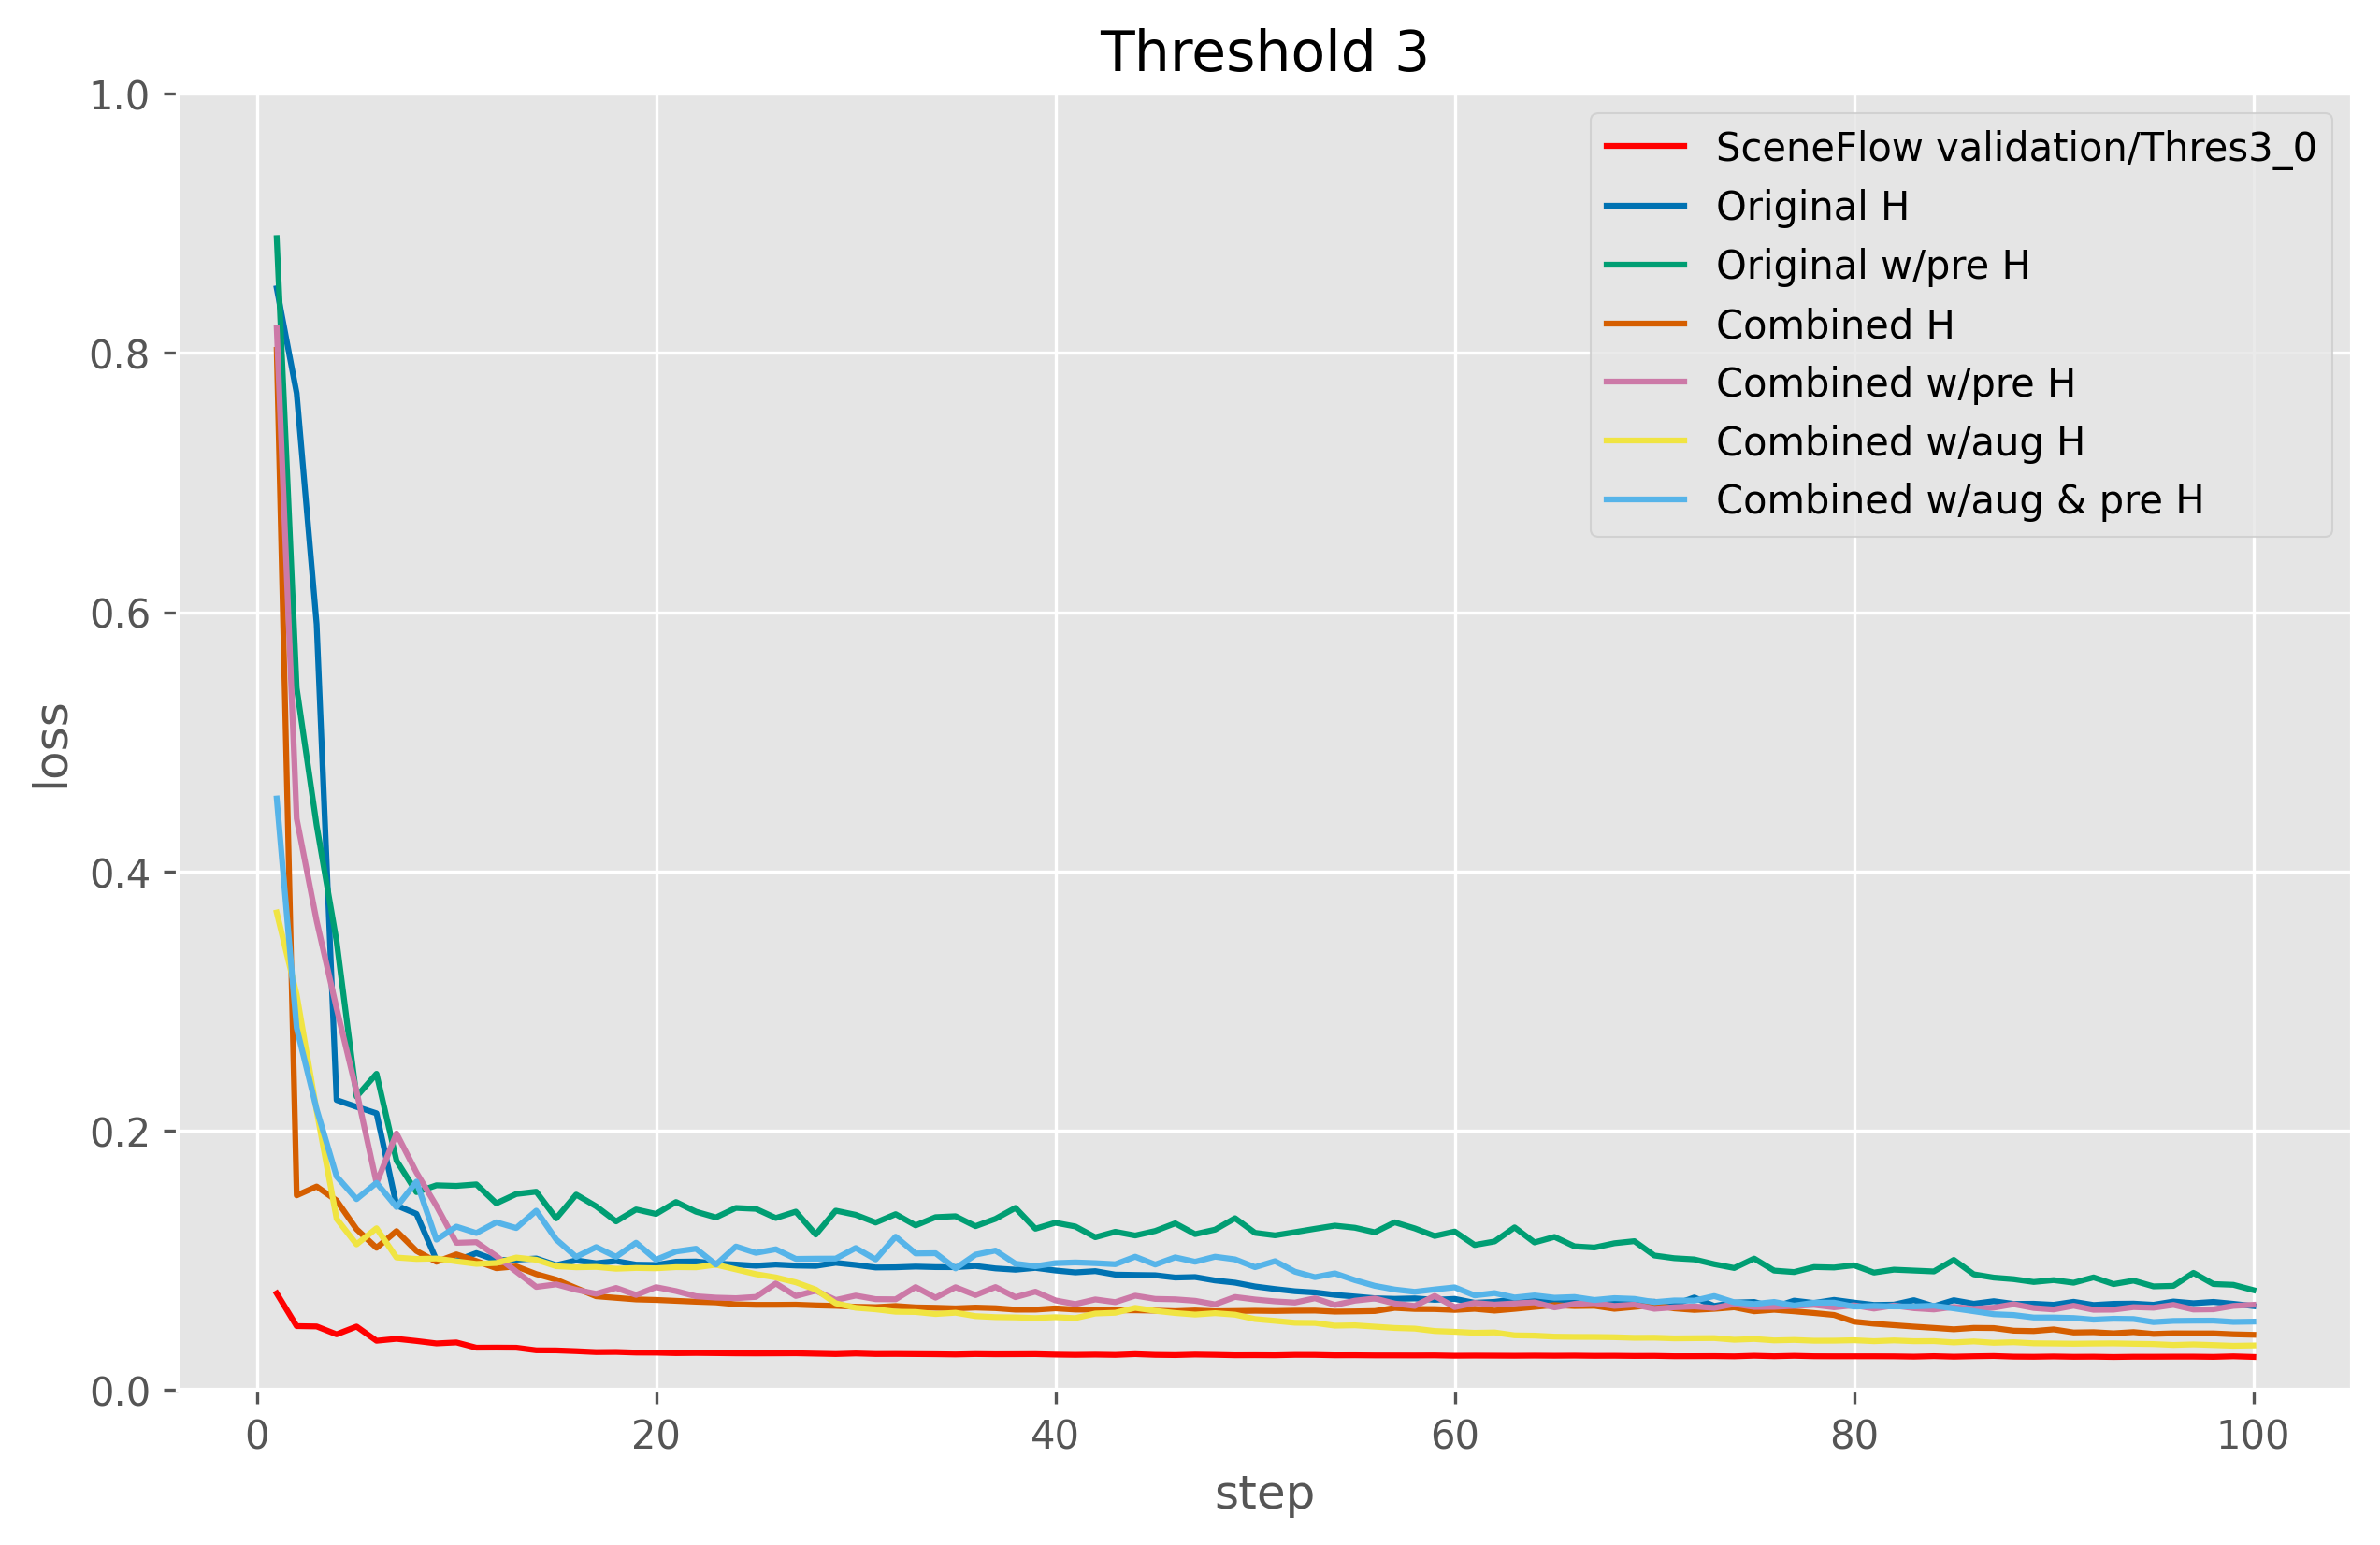

In [77]:
for key, value in column_plot_combinations.items():
    print(key)
    plt.figure(figsize=(10, 6), dpi=300)
    for column in value:
        plt.plot(SceneFlow['step'], SceneFlow[column], label=f'SceneFlow {column}', color=model_colors['SceneFlow'])
        plt.plot(Original['step'], Original[column],                 label=f'Original H',              color=model_colors['ScapeOriginal'])
        plt.plot(Original_pre['step'], Original_pre[column],         label=f'Original w/pre H',             color=model_colors['ScapeOriginal_pretrained'])
        plt.plot(Combined['step'], Combined[column],                 label=f'Combined H',       color=model_colors['ScapeCombined'])
        plt.plot(Combined_pre['step'], Combined_pre[column],         label=f'Combined w/pre H',             color=model_colors['ScapeCombined_pretrained'])
        plt.plot(Combined_aug['step'], Combined_aug[column], label=f'Combined w/aug H',       color=model_colors['ScapeCombinedAugmented'])
        plt.plot(Combined_aug_pre['step'], Combined_aug_pre[column], label=f'Combined w/aug & pre H', color=model_colors['ScapeCombinedAugmented_pretrained'])
    
    if "D1" in key:
        plt.ylim(0, 0.2)
    elif "Thres" in key:
        plt.ylim(0, 1)
    else:
        plt.ylim(0, 3)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.title(key)
    SAVE_PATH = os.path.join(VIS_DIR, f'markdown_resultater_segmentering/{key}_50.png')
    # plt.savefig(SAVE_PATH)
    plt.legend()
    plt.show()

# FULL

In [ ]:
list_of_log_dirs = [os.path.join(BASE_DIR, event) for event in os.listdir(BASE_DIR) if not event.startswith('.')]

list_of_event_files = []
for event in list_of_log_dirs:
    if "Full" not in event:
        continue
    event_file = [event for event in os.listdir(event) if event.startswith('events')]
    if event_file:
        event_file = os.path.join(event, event_file[0])
        list_of_event_files.append(event_file)

# list_of_event_files

In [79]:
name_conversion = {
    'Full_ScapeOriginal': 'Original F',
    'Full_ScapeOriginal_pretrained': 'Original w/pre F',
    'Full_ScapeCombined': 'Combined F',
    'Full_ScapeCombined_pretrained': 'Combined w/pre F',
    'Full_ScapeCombinedAugmented': 'Combined w/aug F',
    'Full_ScapeCombinedAugmented_pretrained': 'Combined w/aug & pre F',
}

In [80]:
main_df2 = tensorboard_log_to_df(BASE_DIR, list_of_event_files, name_conversion, show=True)

Pivoted DataFrame: Original F
|            |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-----------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| Original F |     100 |       1.9955 |      1.7716 |    0.0462 |     1.7716 |        0.3042 |        0.1584 |        0.1153 |
Pivoted DataFrame: Combined w/aug & pre F
|                        |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Thres1 |   val. Thres2 |   val. Thres3 |
|:-----------------------|--------:|-------------:|------------:|----------:|-----------:|--------------:|--------------:|--------------:|
| Combined w/aug & pre F |      97 |       2.6512 |      2.4533 |     0.057 |     2.4534 |        0.5131 |        0.2679 |        0.1622 |
Pivoted DataFrame: Combined w/aug F
|                  |   epoch |   train loss |   val. loss |   val. D1 |   val. EPE |   val. Th

<Axes: title={'center': 'Lowest loss values'}, xlabel='Metric', ylabel='Value'>

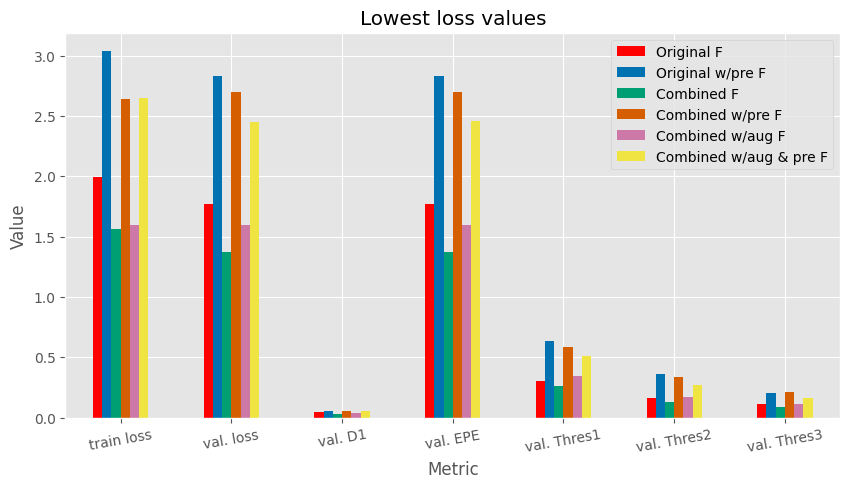

In [81]:
plot_df = main_df2.T.copy()
plot_df = plot_df.drop('epoch')
plot_df.plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Lowest loss values', 
    ylabel='Value', 
    xlabel='Metric', 
    rot=10,
    color = ['#FF0000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9'],
)


In [82]:
# SceneFlow        = extract_df(os.path.join(BASE_DIR, 'Sceneflow'))
Original         = extract_df(os.path.join(BASE_DIR, 'Full_ScapeOriginal'))
Original_pre     = extract_df(os.path.join(BASE_DIR, 'Full_ScapeOriginal_pretrained'))
Combined         = extract_df(os.path.join(BASE_DIR, 'Full_ScapeCombined'))
Combined_pre     = extract_df(os.path.join(BASE_DIR, 'Full_ScapeCombined_pretrained'))
Combined_aug_pre = extract_df(os.path.join(BASE_DIR, 'Full_ScapeCombinedAugmented'))
Combined_aug_pre = extract_df(os.path.join(BASE_DIR, 'Full_ScapeCombinedAugmented_pretrained'))

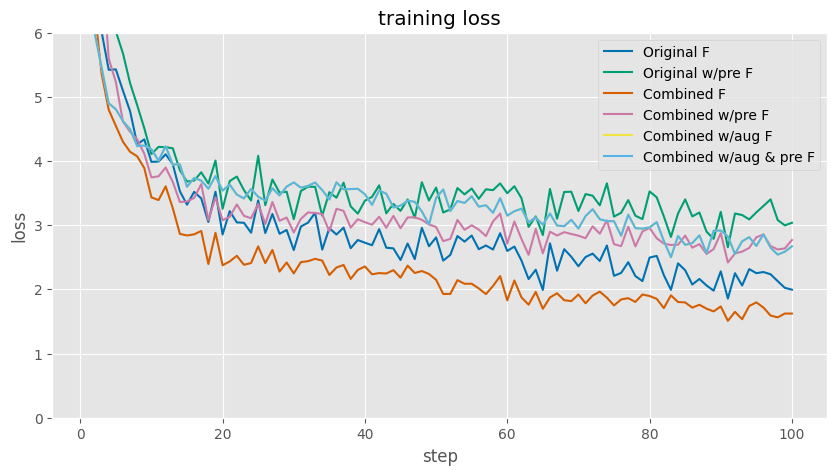

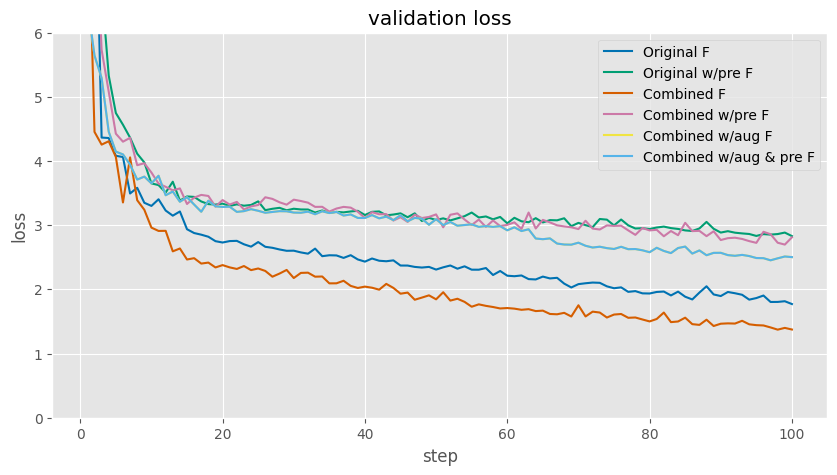

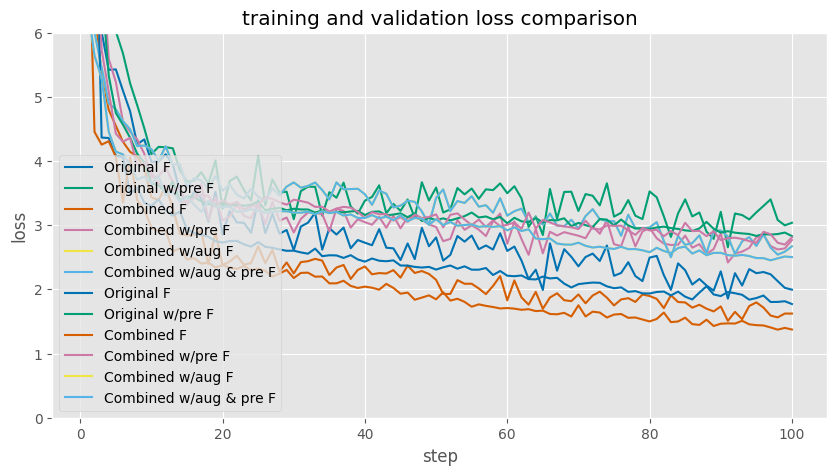

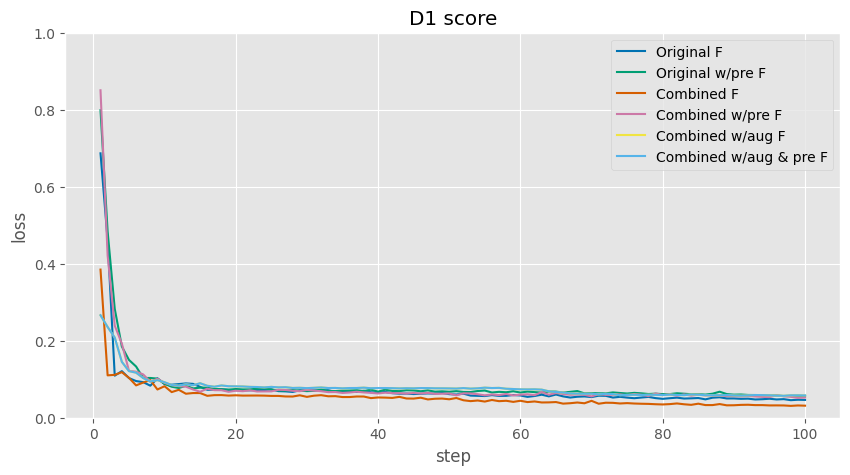

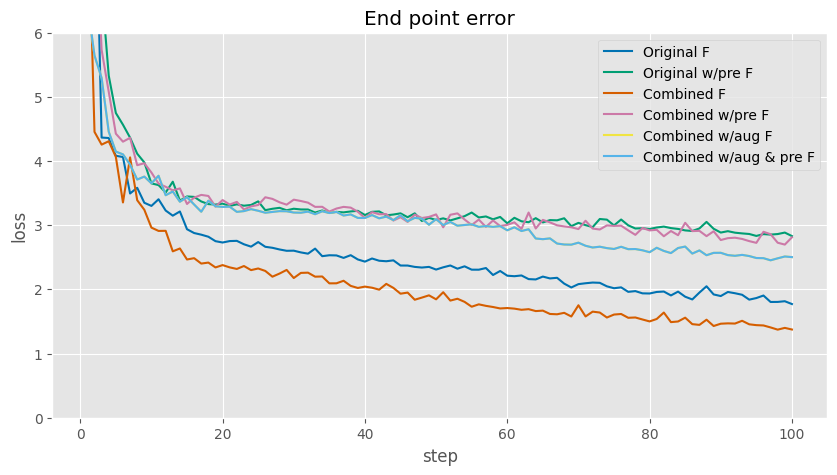

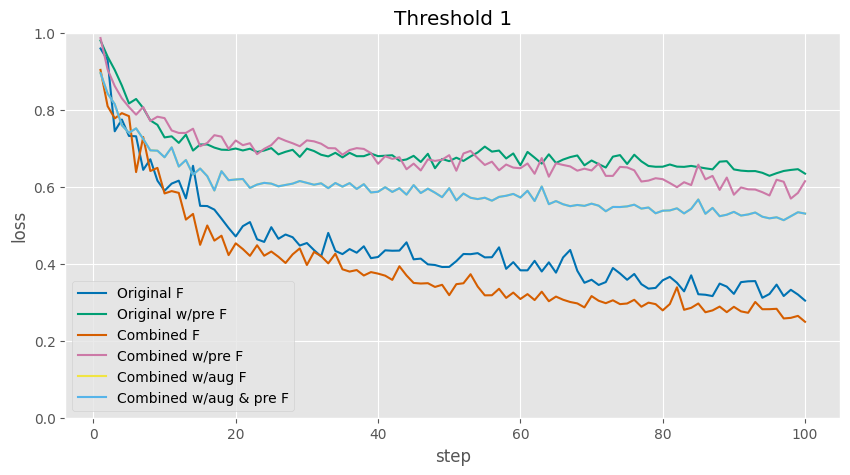

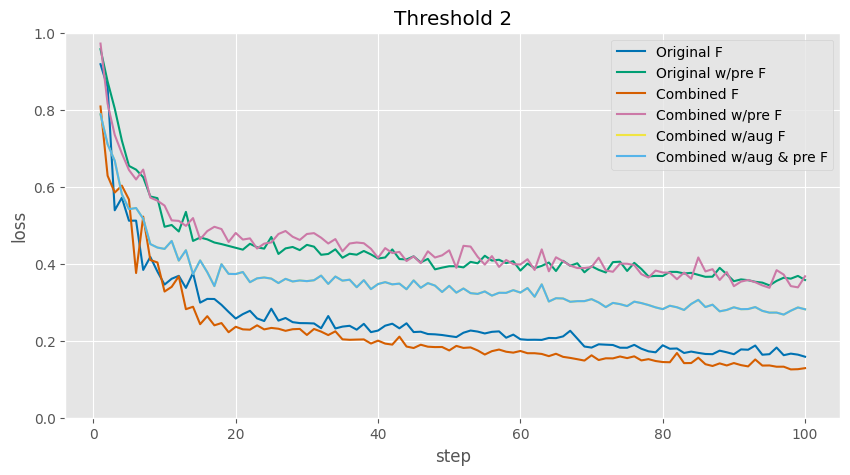

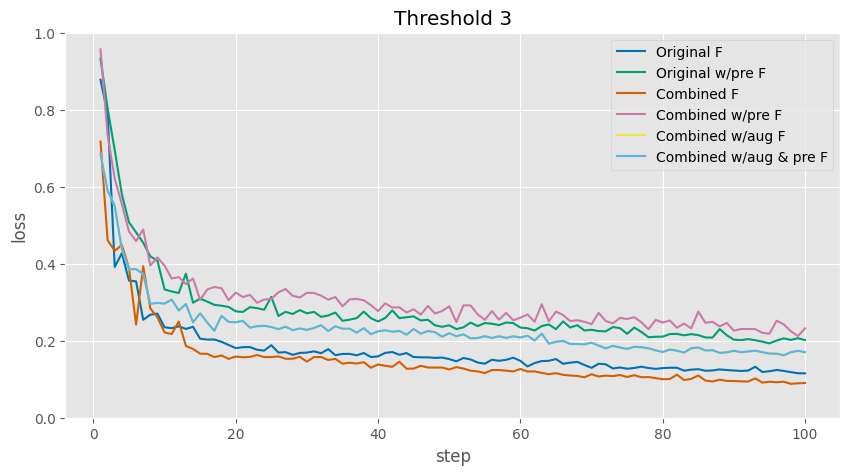

In [83]:
for key, value in column_plot_combinations.items():
    plt.figure(figsize=(10, 5))
    for column in value:
        # plt.plot(SceneFlow['step'], SceneFlow[column], label=f'SceneFlow {column}', color=model_colors['SceneFlow'])
        plt.plot(Original['step'], Original[column],                 label=f'Original F',             color=model_colors['ScapeOriginal'])
        plt.plot(Original_pre['step'], Original_pre[column],         label=f'Original w/pre F',       color=model_colors['ScapeOriginal_pretrained'])
        plt.plot(Combined['step'], Combined[column],                 label=f'Combined F',             color=model_colors['ScapeCombined'])
        plt.plot(Combined_pre['step'], Combined_pre[column],         label=f'Combined w/pre F',       color=model_colors['ScapeCombined_pretrained'])
        plt.plot(Combined_aug_pre['step'], Combined_aug_pre[column], label=f'Combined w/aug F',       color=model_colors['ScapeCombinedAugmented'])
        plt.plot(Combined_aug_pre['step'], Combined_aug_pre[column], label=f'Combined w/aug & pre F', color=model_colors['ScapeCombinedAugmented_pretrained'])
    
    if "D1" in key or "Thres" in key:
        plt.ylim(0, 1)
    else:
        plt.ylim(0, 6)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.title(key)
    SAVE_PATH = os.path.join(VIS_DIR, f'markdown_resultater_segmentering/{key}_50.png')
    # plt.savefig(SAVE_PATH)
    plt.legend()
    plt.show()

# Combined barplot

In [84]:
combined_df = pd.concat([main_df1, main_df2], axis=0)
combined_df

tag                     epoch  train loss  val. loss  val. D1  val. EPE  \
SceneFlow                98.0      1.2530     0.6110   0.0200    0.6150   
Original H               95.0      0.7950     0.9590   0.0500    0.9590   
Original w/pre H        100.0      0.9560     1.2110   0.0570    1.2110   
Combined H              100.0      0.5700     0.6300   0.0280    0.6300   
Combined w/pre H         97.0      0.8610     1.0850   0.0480    1.0850   
Combined w/aug H         99.0      0.5120     0.5180   0.0240    0.5180   
Combined w/aug & pre H   95.0      0.7850     0.8720   0.0370    0.8720   
Original F              100.0      1.9955     1.7716   0.0462    1.7716   
Original w/pre F        100.0      3.0379     2.8308   0.0559    2.8309   
Combined F               98.0      1.5638     1.3727   0.0308    1.3727   
Combined w/pre F         99.0      2.6386     2.6981   0.0516    2.6982   
Combined w/aug F         88.0      1.5961     1.5927   0.0376    1.5922   
Combined w/aug & pre F   97.0      2.6512     2.4533   0.0570    2.4534   

tag                     val. Thres1  val. Thres2  val. Thres3  
SceneFlow                    0.0690       0.0360       0.0260  
Original H                   0.1580       0.0890       0.0660  
Original w/pre H             0.2550       0.1260       0.0770  
Combined H                   0.1200       0.0650       0.0420  
Combined w/pre H             0.2300       0.0950       0.0620  
Combined w/aug H             0.0920       0.0490       0.0340  
Combined w/aug & pre H       0.1890       0.0770       0.0520  
Original F                   0.3042       0.1584       0.1153  
Original w/pre F             0.6340       0.3578       0.2017  
Combined F                   0.2594       0.1255       0.0881  
Combined w/pre F             0.5840       0.3386       0.2123  
Combined w/aug F             0.3442       0.1703       0.1153  
Combined w/aug & pre F       0.5131       0.2679       0.1622

In [85]:
combined_df.T.to_dict()

{'SceneFlow': {'epoch': 98.0,
  'train loss': 1.253,
  'val. loss': 0.611,
  'val. D1': 0.02,
  'val. EPE': 0.615,
  'val. Thres1': 0.069,
  'val. Thres2': 0.036,
  'val. Thres3': 0.026},
 'Original H': {'epoch': 95.0,
  'train loss': 0.795,
  'val. loss': 0.959,
  'val. D1': 0.05,
  'val. EPE': 0.959,
  'val. Thres1': 0.158,
  'val. Thres2': 0.089,
  'val. Thres3': 0.066},
 'Original w/pre H': {'epoch': 100.0,
  'train loss': 0.956,
  'val. loss': 1.211,
  'val. D1': 0.057,
  'val. EPE': 1.211,
  'val. Thres1': 0.255,
  'val. Thres2': 0.126,
  'val. Thres3': 0.077},
 'Combined H': {'epoch': 100.0,
  'train loss': 0.57,
  'val. loss': 0.63,
  'val. D1': 0.028,
  'val. EPE': 0.63,
  'val. Thres1': 0.12,
  'val. Thres2': 0.065,
  'val. Thres3': 0.042},
 'Combined w/pre H': {'epoch': 97.0,
  'train loss': 0.861,
  'val. loss': 1.085,
  'val. D1': 0.048,
  'val. EPE': 1.085,
  'val. Thres1': 0.23,
  'val. Thres2': 0.095,
  'val. Thres3': 0.062},
 'Combined w/aug H': {'epoch': 99.0,
  'trai

In [86]:
print(combined_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrr}
\toprule
tag & epoch & train loss & val. loss & val. D1 & val. EPE & val. Thres1 & val. Thres2 & val. Thres3 \\
\midrule
SceneFlow & 98.000 & 1.253 & 0.611 & 0.020 & 0.615 & 0.069 & 0.036 & 0.026 \\
Original H & 95.000 & 0.795 & 0.959 & 0.050 & 0.959 & 0.158 & 0.089 & 0.066 \\
Original w/pre H & 100.000 & 0.956 & 1.211 & 0.057 & 1.211 & 0.255 & 0.126 & 0.077 \\
Combined H & 100.000 & 0.570 & 0.630 & 0.028 & 0.630 & 0.120 & 0.065 & 0.042 \\
Combined w/pre H & 97.000 & 0.861 & 1.085 & 0.048 & 1.085 & 0.230 & 0.095 & 0.062 \\
Combined w/aug H & 99.000 & 0.512 & 0.518 & 0.024 & 0.518 & 0.092 & 0.049 & 0.034 \\
Combined w/aug & pre H & 95.000 & 0.785 & 0.872 & 0.037 & 0.872 & 0.189 & 0.077 & 0.052 \\
Original F & 100.000 & 1.996 & 1.772 & 0.046 & 1.772 & 0.304 & 0.158 & 0.115 \\
Original w/pre F & 100.000 & 3.038 & 2.831 & 0.056 & 2.831 & 0.634 & 0.358 & 0.202 \\
Combined F & 98.000 & 1.564 & 1.373 & 0.031 & 1.373 & 0.259 & 0.126 & 0.088 \\
Combined w/pre F & 99.0

<Axes: title={'center': 'Lowest loss values'}, xlabel='Metric', ylabel='Value'>

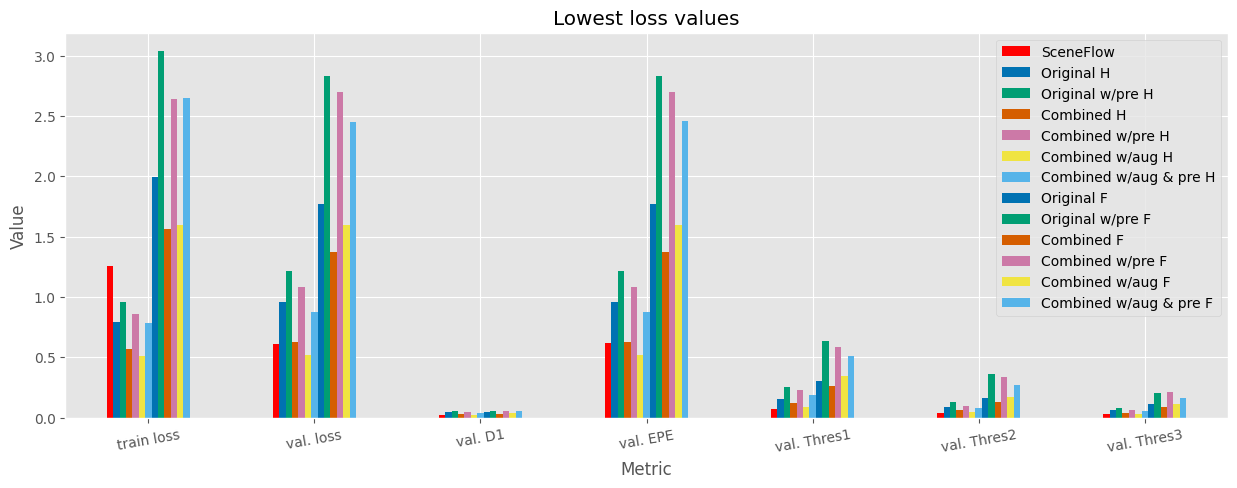

In [87]:
plot_df = combined_df.T.copy()
plot_df = plot_df.drop('epoch')
plot_df.plot(
    kind='bar', 
    figsize=(15, 5), 
    title='Lowest loss values', 
    ylabel='Value', 
    xlabel='Metric', 
    rot=10,
    color = ['#FF0000', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9',],
)

# Disparity domain codomain

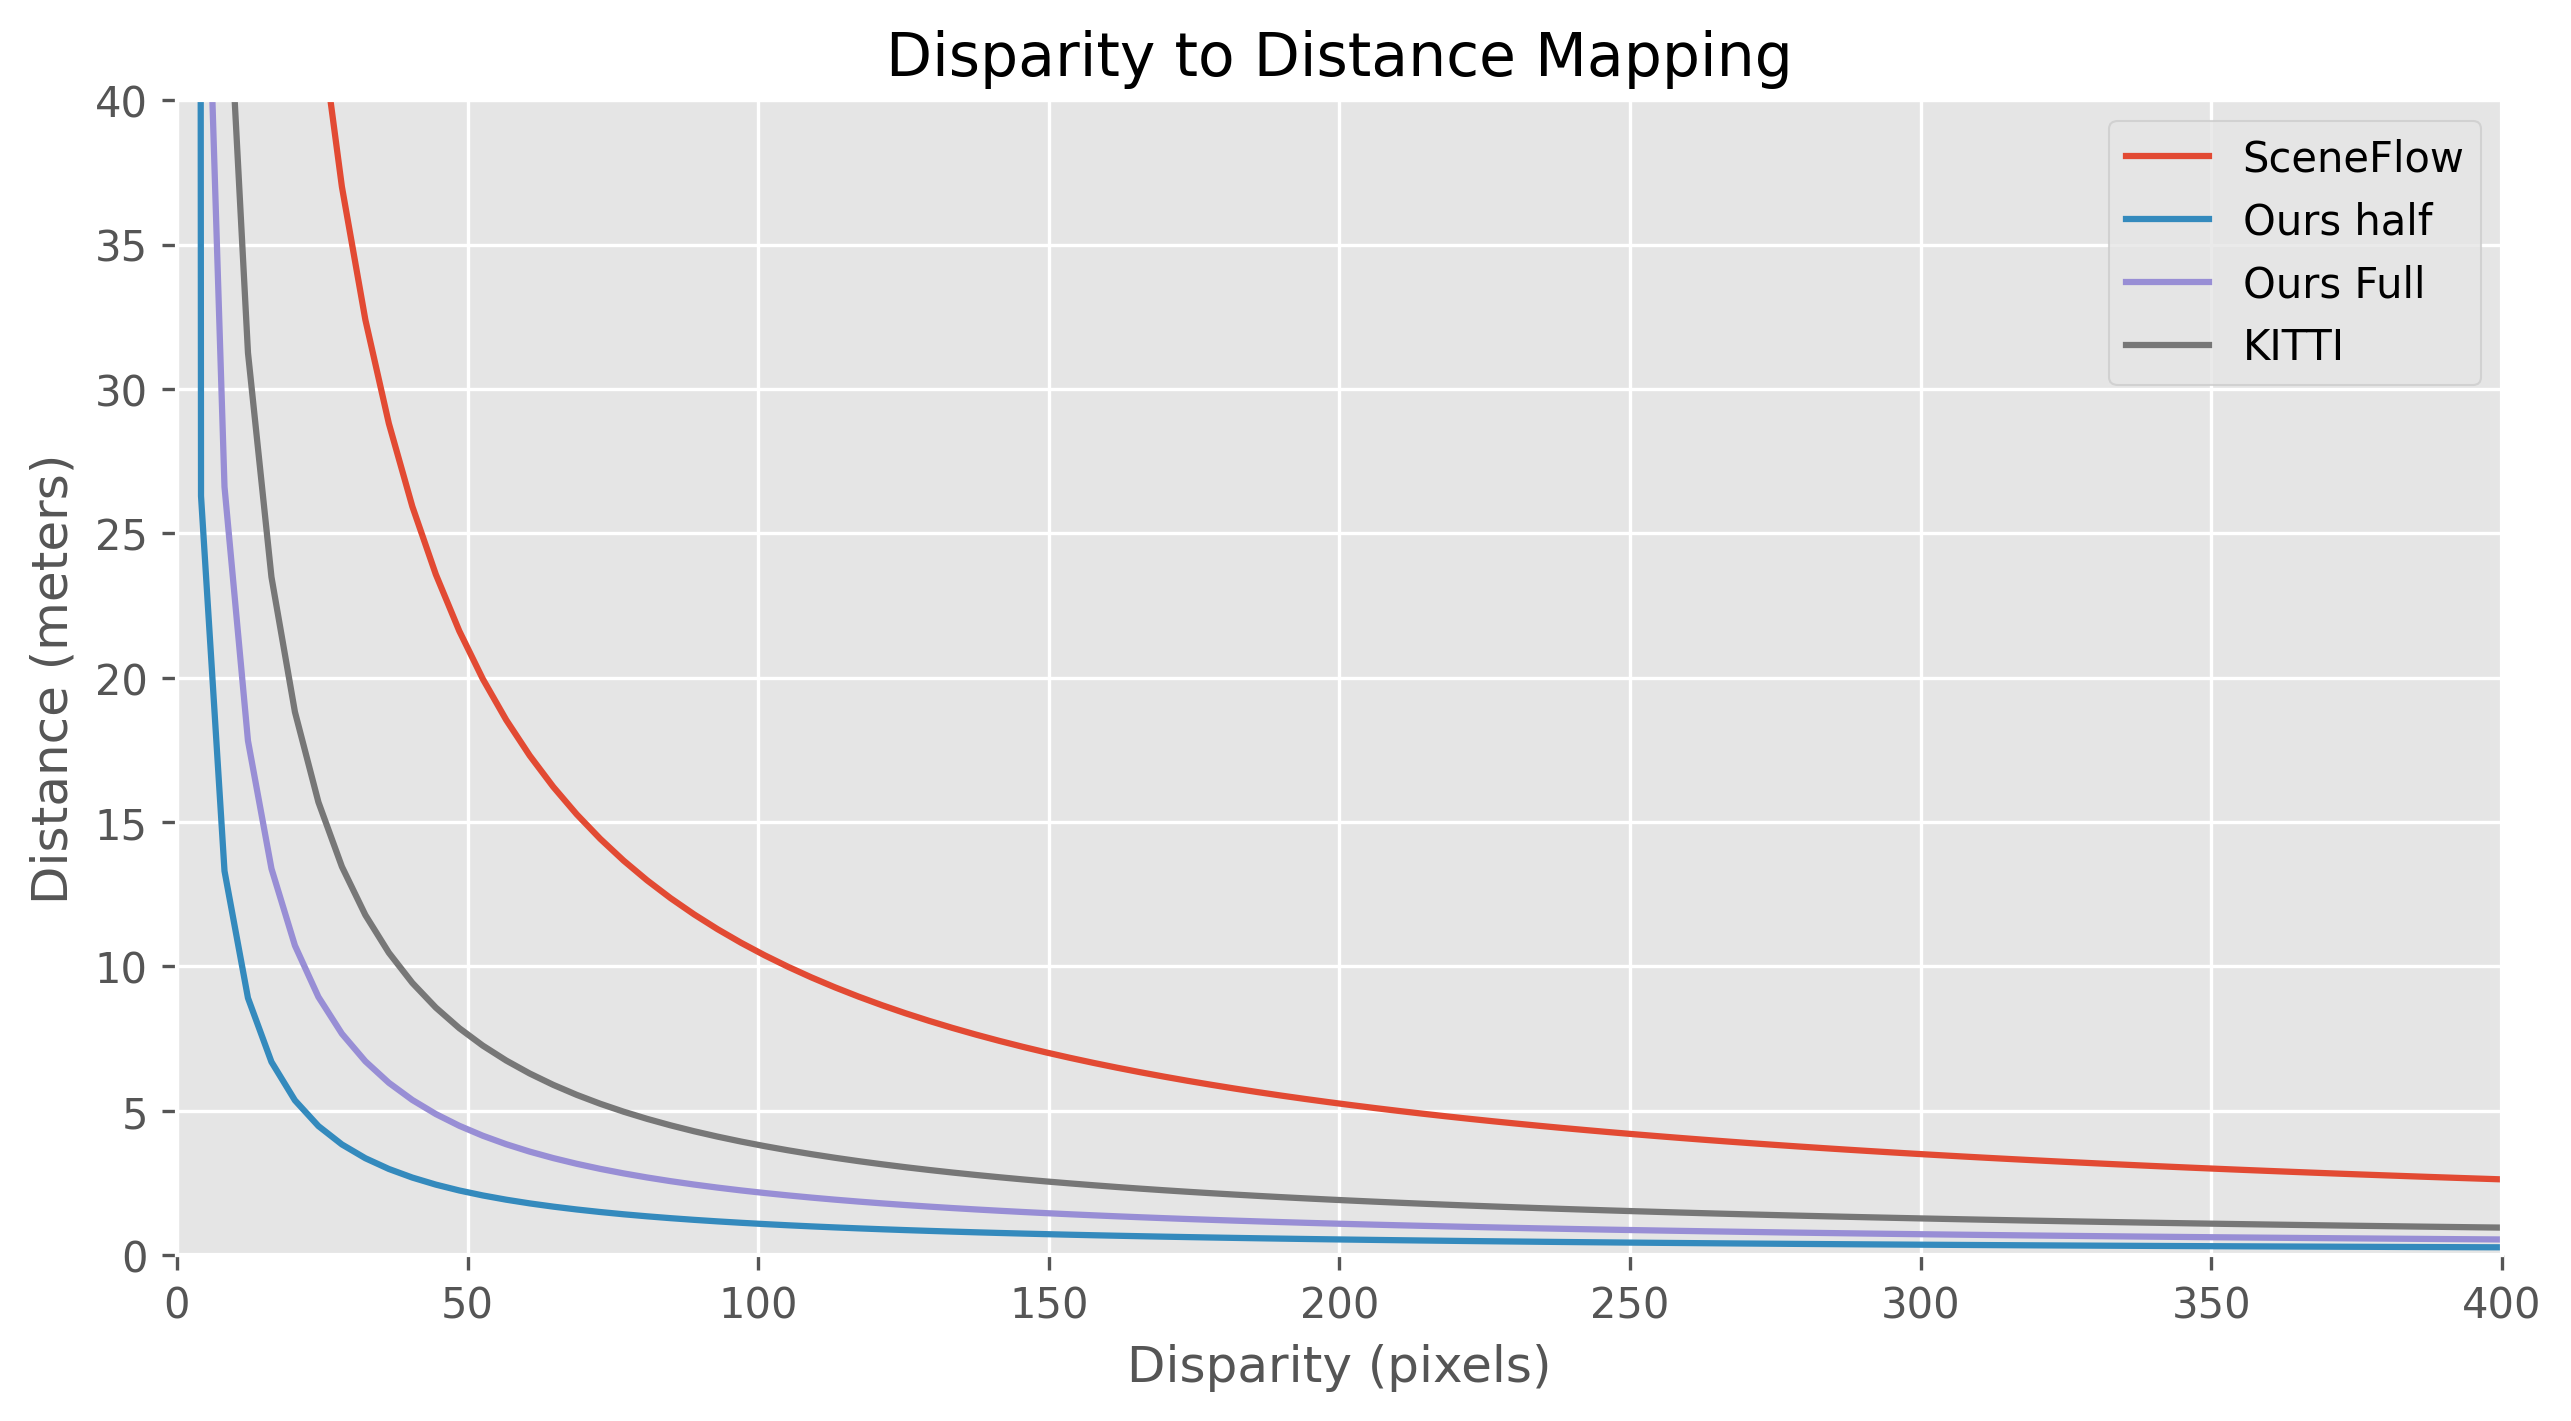

In [88]:
SCENEFLOW_FL = 1050
SCENEFLOW_BL = 1.0

OURS_HALF_FL = 989.2787524366472
OURS_HALF_BL = 0.11

OURS_FULL_FL = 1978.5575048732944
OURS_FULL_BL = 0.11

KITTI_FL = 707.0912
KITTI_BL  = 0.54

disparity_range = np.linspace(0.1, 400, 100)

SF_DIST = (SCENEFLOW_FL * SCENEFLOW_BL) / disparity_range
OURS_HALF_DIST = (OURS_HALF_FL * OURS_HALF_BL) / disparity_range
OURS_FULL_DIST = (OURS_FULL_FL * OURS_FULL_BL) / disparity_range
KITTI_DIST = (KITTI_FL * KITTI_BL) / disparity_range

plt.figure(figsize=(10, 5), dpi=300)
plt.plot(disparity_range, SF_DIST, label='SceneFlow')
plt.plot(disparity_range, OURS_HALF_DIST, label='Ours half')
plt.plot(disparity_range, OURS_FULL_DIST, label='Ours Full')
plt.plot(disparity_range, KITTI_DIST, label='KITTI')
plt.xlabel('Disparity (pixels)')
plt.ylabel('Distance (meters)')
plt.title('Disparity to Distance Mapping')
plt.xlim(0, 400)
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.show()

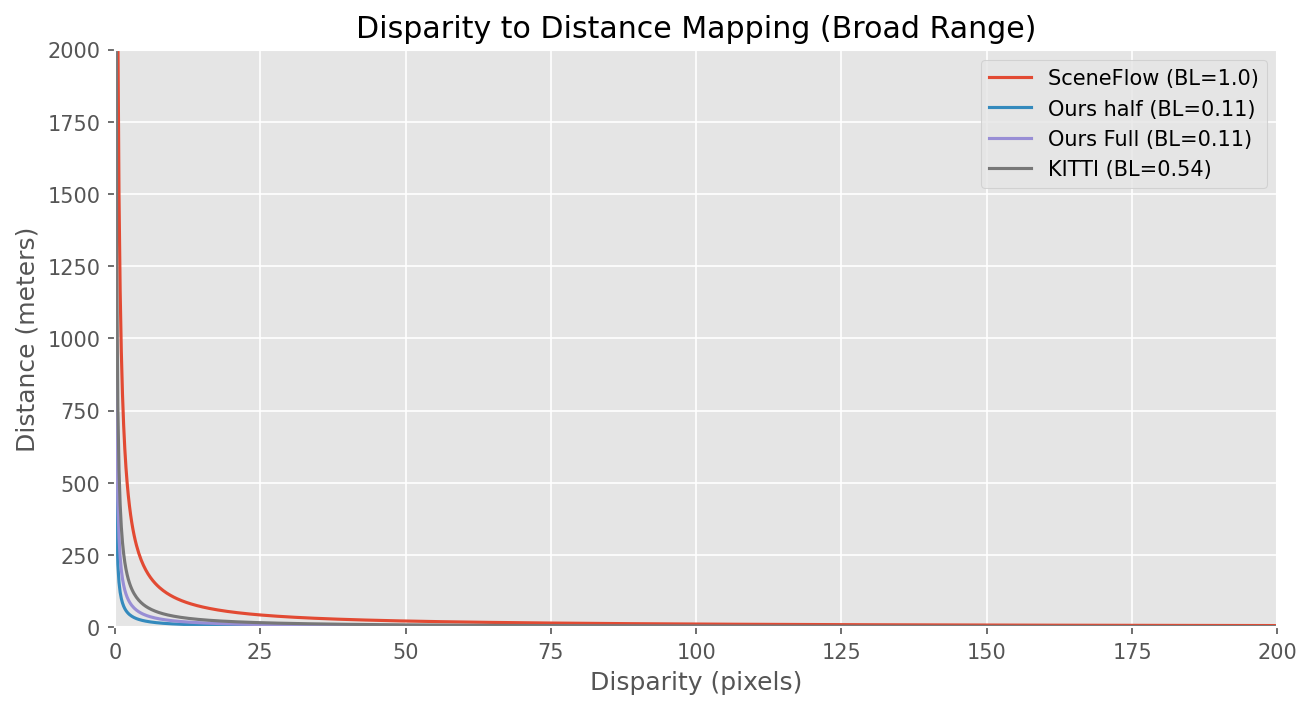

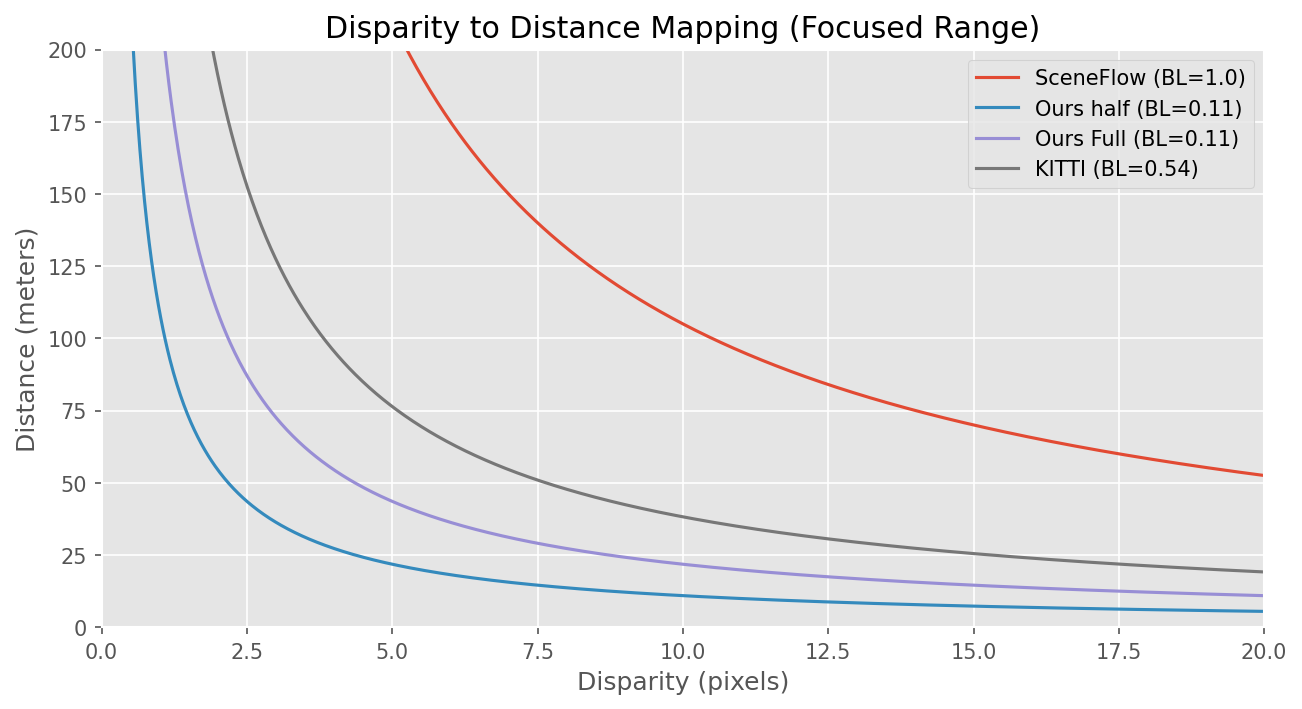

In [89]:
SCENEFLOW_FL = 1050
SCENEFLOW_BL = 1.0

OURS_HALF_FL = 989.2787524366472
OURS_HALF_BL = 0.11

OURS_FULL_FL = 1978.5575048732944
OURS_FULL_BL = 0.11

KITTI_FL = 707.0912
KITTI_BL = 0.54

disparity_range = np.linspace(0.1, 200, 1000)

SF_DIST = (SCENEFLOW_FL * SCENEFLOW_BL) / disparity_range
OURS_HALF_DIST = (OURS_HALF_FL * OURS_HALF_BL) / disparity_range
OURS_FULL_DIST = (OURS_FULL_FL * OURS_FULL_BL) / disparity_range
KITTI_DIST = (KITTI_FL * KITTI_BL) / disparity_range

plt.figure(figsize=(10, 5), dpi=150)
plt.plot(disparity_range, SF_DIST, label='SceneFlow (BL=1.0)')
plt.plot(disparity_range, OURS_HALF_DIST, label='Ours half (BL=0.11)')
plt.plot(disparity_range, OURS_FULL_DIST, label='Ours Full (BL=0.11)')
plt.plot(disparity_range, KITTI_DIST, label='KITTI (BL=0.54)')
plt.xlabel('Disparity (pixels)')
plt.ylabel('Distance (meters)')
plt.title('Disparity to Distance Mapping (Broad Range)')
plt.xlim(0, 200)
plt.ylim(0, 2000)
plt.legend()
plt.grid(True)
plt.show()

disparity_range_focus = np.linspace(0.1, 20, 1000)
SF_DIST_FOCUS = (SCENEFLOW_FL * SCENEFLOW_BL) / disparity_range_focus
OURS_HALF_DIST_FOCUS = (OURS_HALF_FL * OURS_HALF_BL) / disparity_range_focus
OURS_FULL_DIST_FOCUS = (OURS_FULL_FL * OURS_FULL_BL) / disparity_range_focus
KITTI_DIST_FOCUS = (KITTI_FL * KITTI_BL) / disparity_range_focus

plt.figure(figsize=(10, 5), dpi=150)
plt.plot(disparity_range_focus, SF_DIST_FOCUS, label='SceneFlow (BL=1.0)')
plt.plot(disparity_range_focus, OURS_HALF_DIST_FOCUS, label='Ours half (BL=0.11)')
plt.plot(disparity_range_focus, OURS_FULL_DIST_FOCUS, label='Ours Full (BL=0.11)')
plt.plot(disparity_range_focus, KITTI_DIST_FOCUS, label='KITTI (BL=0.54)')
plt.xlabel('Disparity (pixels)')
plt.ylabel('Distance (meters)')
plt.title('Disparity to Distance Mapping (Focused Range)')
plt.xlim(0, 20)
plt.ylim(0, 200)
plt.legend()
plt.grid(True)
plt.show()

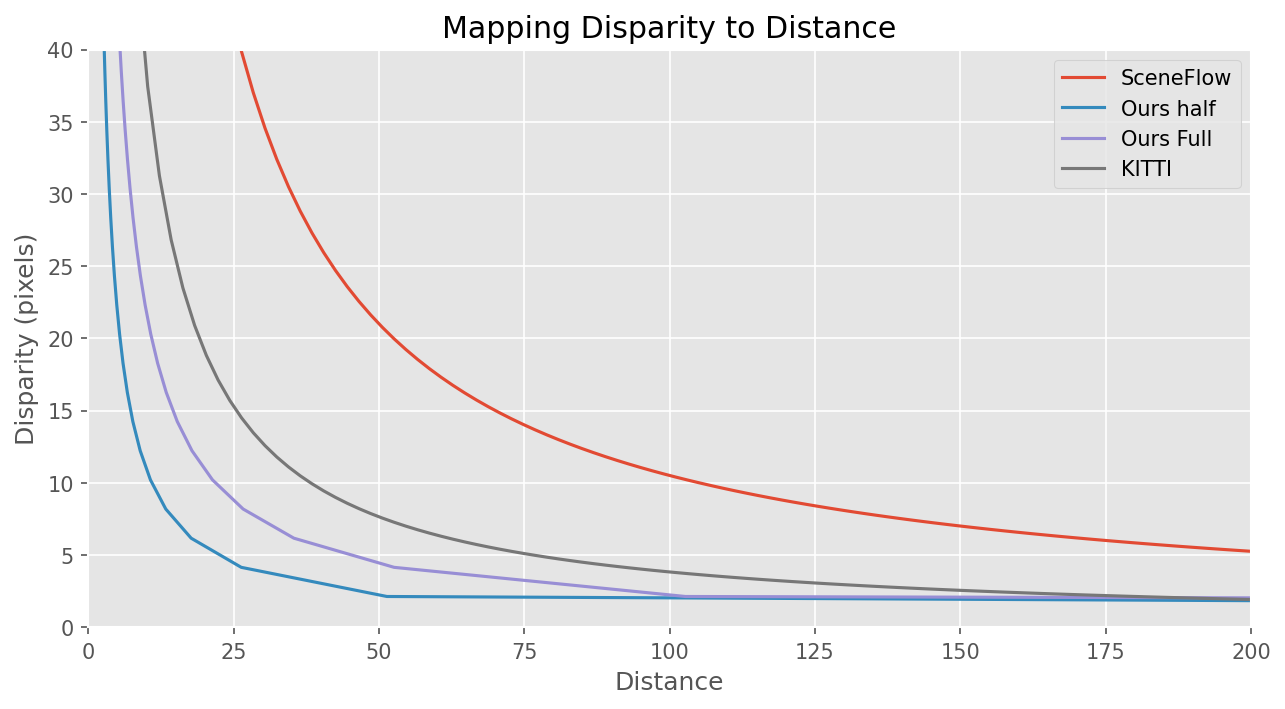

In [90]:
# Parameters
SCENEFLOW_FL = 1050  # Focal length in pixels
SCENEFLOW_BL = 1.

OURS_HALF_FL = 989.2787524366472
OURS_HALF_BL = 0.11

OURS_FULL_FL = 1978.5575048732944
OURS_FULL_BL = 0.11

KITTI_FL = 707.0912
KITTI_BL  = 0.54

# Disparities from 0.1 to 90
SF_DISP = np.linspace(0.1, 200, 100)  # Using 0.1 instead of 0 to avoid division by zero
ORURS_HALF_DISP = np.linspace(0.1, 200, 100)  # Using 0.1 instead of 0 to avoid division by zero
ORURS_FULL_DISP = np.linspace(0.1, 200, 100)  # Using 0.1 instead of 0 to avoid division by zero
KITTI_DISP = np.linspace(0.1, 200, 100)  # Using 0.1 instead of 0 to avoid division by zero

# Calculate distances
SF_DIST = (SCENEFLOW_FL * SCENEFLOW_BL) / SF_DISP
OURS_HALF_DIST = (OURS_HALF_FL * OURS_HALF_BL) / ORURS_HALF_DISP
OURS_FULL_DIST = (OURS_FULL_FL * OURS_FULL_BL) / ORURS_FULL_DISP
KITTI_DIST = (KITTI_FL * KITTI_BL) / KITTI_DISP

# Plotting
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(SF_DISP, SF_DIST, label='SceneFlow')
plt.plot(OURS_HALF_DIST, ORURS_HALF_DISP, label='Ours half')
plt.plot(OURS_FULL_DIST, ORURS_FULL_DISP, label='Ours Full')
plt.plot(KITTI_DISP, KITTI_DIST, label='KITTI')
plt.xlabel('Distance')
plt.ylabel('Disparity (pixels)')
plt.title('Mapping Disparity to Distance')
plt.xlim(0, 200)
plt.ylim(0, 40)
plt.legend()
plt.grid(True)
plt.show()


In [91]:
def average_change_in_distance_per_disparity(focal_length, baseline, distance_range):
    disparities = (focal_length * baseline) / distance_range
    min_disparity = np.min(disparities)
    max_disparity = np.max(disparities)
    distances = (focal_length * baseline) / disparities
    delta_distances = np.diff(distances)
    delta_disparities = np.diff(disparities)
    avg_change_per_disparity = (np.mean(np.abs(delta_distances / delta_disparities)))*100
    return avg_change_per_disparity

focal_length_sceneflow = 1050
baseline_sceneflow = 1.0

focal_length_ours_half = 989.2787524366472
baseline_ours_half = 0.11

focal_length_ours_full = 1978.5575048732944
baseline_ours_full = 0.11

focal_length_kitti = 707.0912
baseline_kitti = 0.54

distance_range = np.linspace(0.5, 1.5, 1000)

avg_change_sceneflow = average_change_in_distance_per_disparity(focal_length_sceneflow, baseline_sceneflow, distance_range)
avg_change_ours_half = average_change_in_distance_per_disparity(focal_length_ours_half, baseline_ours_half, distance_range)
avg_change_ours_full = average_change_in_distance_per_disparity(focal_length_ours_full, baseline_ours_full, distance_range)
avg_change_kitti     = average_change_in_distance_per_disparity(focal_length_kitti, baseline_kitti, distance_range)

print(f"SceneFlow (BL=1.0)  : {avg_change_sceneflow:.6f} CM per pixel disparity")
print(f"Ours Half (BL=0.11) : {avg_change_ours_half:.6f} CM per pixel disparity")
print(f"Ours Full (BL=0.11) : {avg_change_ours_full:.6f} CM per pixel disparity")
print(f"KITTI (BL=0.54)     : {avg_change_kitti:.6f} CM per pixel disparity")

SceneFlow (BL=1.0)  : 0.103175 CM per pixel disparity
Ours Half (BL=0.11) : 0.995521 CM per pixel disparity
Ours Full (BL=0.11) : 0.497761 CM per pixel disparity
KITTI (BL=0.54)     : 0.283722 CM per pixel disparity


In [92]:
def average_change_in_distance_per_disparity(focal_length, baseline, distance_range):
    disparities = (focal_length * baseline) / distance_range
    distances = (focal_length * baseline) / disparities
    delta_distances = np.diff(distances)
    delta_disparities = np.diff(disparities)
    avg_change_per_disparity = np.mean(np.abs(delta_distances / delta_disparities)) * 100
    min_disparity = np.min(disparities)
    max_disparity = np.max(disparities)
    return avg_change_per_disparity, min_disparity, max_disparity

focal_length_sceneflow = 1050
baseline_sceneflow = 1.0

focal_length_ours_half = 989.2787524366472
baseline_ours_half = 0.11

focal_length_ours_full = 1978.5575048732944
baseline_ours_full = 0.11

focal_length_kitti = 707.0912
baseline_kitti = 0.54

distance_range = np.linspace(1., 1.5, 1000)

avg_change_sceneflow, min_disp_sceneflow, max_disp_sceneflow = average_change_in_distance_per_disparity(focal_length_sceneflow, baseline_sceneflow, distance_range)
avg_change_ours_half, min_disp_ours_half, max_disp_ours_half = average_change_in_distance_per_disparity(focal_length_ours_half, baseline_ours_half, distance_range)
avg_change_ours_full, min_disp_ours_full, max_disp_ours_full = average_change_in_distance_per_disparity(focal_length_ours_full, baseline_ours_full, distance_range)
avg_change_kitti, min_disp_kitti, max_disp_kitti = average_change_in_distance_per_disparity(focal_length_kitti, baseline_kitti, distance_range)

print(f"SceneFlow (BL=1.0) : {avg_change_sceneflow:.6f} meters per pixel disparity, Disparity Range: {min_disp_sceneflow:.2f} - {max_disp_sceneflow:.2f}")
print(f"Ours Half (BL=0.11): {avg_change_ours_half:.6f} meters per pixel disparity, Disparity Range: {min_disp_ours_half:.2f} - {max_disp_ours_half:.2f}")
print(f"Ours Full (BL=0.11): {avg_change_ours_full:.6f} meters per pixel disparity, Disparity Range: {min_disp_ours_full:.2f} - {max_disp_ours_full:.2f}")
print(f"KITTI (BL=0.54)    : {avg_change_kitti:.6f} meters per pixel disparity, Disparity Range: {min_disp_kitti:.2f} - {max_disp_kitti:.2f}")

SceneFlow (BL=1.0) : 0.150794 meters per pixel disparity, Disparity Range: 700.00 - 1050.00
Ours Half (BL=0.11): 1.454993 meters per pixel disparity, Disparity Range: 72.55 - 108.82
Ours Full (BL=0.11): 0.727497 meters per pixel disparity, Disparity Range: 145.09 - 217.64
KITTI (BL=0.54)    : 0.414670 meters per pixel disparity, Disparity Range: 254.55 - 381.83


In [93]:
SCENEFLOW_FL = 1050
SCENEFLOW_BL = 1.
OURS_HALF_FL = 989.2787524366472
OURS_HALF_BL = 0.31
OURS_FULL_FL = 1978.5575048732944
OURS_FULL_BL = 0.31
KITTI_FL = 707.0912
KITTI_BL  = 0.54

disparity_values = [50, 100]

def calculate_distance(focal_length, baseline, disparity):
    return (focal_length * baseline) / disparity

sf_distances = [calculate_distance(SCENEFLOW_FL, SCENEFLOW_BL, d) for d in disparity_values]

ours_half_distances = [calculate_distance(OURS_HALF_FL, OURS_HALF_BL, d) for d in disparity_values]

ours_full_distances = [calculate_distance(OURS_FULL_FL, OURS_FULL_BL, d) for d in disparity_values]

kitti_distances = [calculate_distance(KITTI_FL, KITTI_BL, d) for d in disparity_values]

print("SceneFlow Distances:", sf_distances)
print("Ours Half Distances:", ours_half_distances)
print("Ours Full Distances:", ours_full_distances)
print("KITTI Distances:", kitti_distances)


SceneFlow Distances: [21.0, 10.5]
Ours Half Distances: [6.133528265107213, 3.0667641325536064]
Ours Full Distances: [12.267056530214425, 6.133528265107213]
KITTI Distances: [7.63658496, 3.81829248]


In [94]:
ours_full_distances[0] - ours_full_distances[1]

6.133528265107213

In [95]:
((ours_half_distances[0] - ours_half_distances[1])*100)/28

10.952729044834308

In [96]:
((ours_full_distances[0] - ours_full_distances[1])*100)/60

10.222547108512021